In [1]:
from datasets import (
    create_valid_dataset_multi, create_valid_loader
)
from datasets_DDSM import (
    create_test_dataset_DDSM_multi
)
from models_multiview.create_multiview_model import create_model
from torch_utils import utils
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
from tqdm import tqdm
from utils import transforms as T
import torch
import argparse
import yaml
import torchvision
import torchvision.transforms.functional as F
import time
import numpy as np
from torch_utils import froc
import matplotlib.pyplot as plt
import cv2
torch.multiprocessing.set_sharing_strategy('file_system')
from typing import Dict, List, Optional, Tuple, Union
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
data_configs= {
    'TRAIN_DIR_IMAGES' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
    'TRAIN_DIR_LABELS' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
    'VALID_DIR_IMAGES' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
    'VALID_DIR_LABELS' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
# Class names.
    'CLASSES' :[
    '__background__',
    'Mass',


],

# Number of classes (object classes + 1 for background class in Faster RCNN).
    'NC' : 2,

# Whether to save the predictions of the validation set while training.
    'SAVE_VALID_PREDICTION_IMAGES' : True,
}
data_configs

{'TRAIN_DIR_IMAGES': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
 'TRAIN_DIR_LABELS': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
 'VALID_DIR_IMAGES': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
 'VALID_DIR_LABELS': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
 'CLASSES': ['__background__', 'Mass'],
 'NC': 2,
 'SAVE_VALID_PREDICTION_IMAGES': True}

In [3]:
args={
    'model' : 'multiview_detector_swint',
    'weights' : 'outputs/training/multi_swint_crop_small_eval2_40/best_model.pth',
    'batch' : 1,
    'workers': 8,
    'device' : 'cpu',
    'imgsz' : (500, 1200),
    
}

In [4]:
from typing import Dict, List, Optional, Tuple
import math
from collections import OrderedDict
import torch
import torch.nn.functional as F
import torchvision
from torch import nn, Tensor
from torchvision.ops import boxes as box_ops, roi_align
from torchvision.models.detection.roi_heads import RoIHeads 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from detection.transformer import CrossviewTransformer
from detection.position_encoding import PositionEmbeddingSine
from detection.loss import fastrcnn_loss1, Mix_loss, Focal_loss_l1



def pad_sequence(sequences, batch_first=True, padding_value=0):
    """
    Pad a list of variable length tensors with zeros to create a tensor with uniform shape.
    Args:
        sequences: list of PyTorch tensors
        batch_first: If True, the returned tensor will have shape (batch_size, max_sequence_length, *)
                     If False, the returned tensor will have shape (max_sequence_length, batch_size, *)
        padding_value: The value used to pad the sequences
    Returns:
        A PyTorch tensor of shape (batch_size, max_sequence_length, *) or (max_sequence_length, batch_size, *)
    """
    device= sequences[0].device
    # Find the maximum sequence length
    max_length = max([len(seq) for seq in sequences])
    # Pad the sequences with zeros
    padded_sequences = [torch.nn.functional.pad(seq, (0, 0, 0, max_length - len(seq)), value=padding_value) for seq in sequences]

    # Stack the padded sequences into a single tensor
    padded_tensor = torch.stack(padded_sequences, dim=0)
    mask_seq = [len(seq) for seq in sequences]
    mask= torch.zeros(padded_tensor.shape[:2], dtype = torch.bool)
    for i in range(len(sequences)):
        mask[i, mask_seq[i]:] = True
    # Transpose the tensor if batch_first is False
    if not batch_first:
        padded_tensor = padded_tensor.transpose(0, 1)
    padded_tensor = padded_tensor.to(device)
    mask = mask.to(device)
    return padded_tensor, mask




class Multi_roi_heads1(RoIHeads):
    def __init__(self,
        box_roi_pool,
        box_head,
        box_predictor,
        # Faster R-CNN training
        fg_iou_thresh,
        bg_iou_thresh,
        batch_size_per_image,
        positive_fraction,
        bbox_reg_weights,
        # Faster R-CNN inference
        score_thresh,
        nms_thresh,
        detections_per_img,
        # transformer
        use_self_attn,
        # Mask
        mask_roi_pool=None,
        mask_head=None,
        mask_predictor=None,
        keypoint_roi_pool=None,
        keypoint_head=None,
        keypoint_predictor=None,
         
        # compute attention
        compute_attn= False,
        loss_type= 'fasterrcnn1'):
        super().__init__(box_roi_pool,
        box_head,
        box_predictor,
        # Faster R-CNN training
        fg_iou_thresh,
        bg_iou_thresh,
        batch_size_per_image,
        positive_fraction,
        bbox_reg_weights,
        # Faster R-CNN inference
        score_thresh,
        nms_thresh,
        detections_per_img,
        # Mask
        mask_roi_pool=None,
        mask_head=None,
        mask_predictor=None,
        keypoint_roi_pool=None,
        keypoint_head=None,
        keypoint_predictor=None,
        )
        
        
        self.crossview = CrossviewTransformer(use_self_attn=use_self_attn, compute_attn=compute_attn)
        self.pos_encode = PositionEmbeddingSine(512)
        self.loss_type =loss_type 
        if self.loss_type == 'fasterrcnn1':
                self.loss_func = fastrcnn_loss1
        elif self.loss_type == 'mix':
            self.loss_func = Mix_loss
        elif self.loss_type == 'focal':
            self.loss_func= Focal_loss_l1
        else:
            print('wrong loss')
            raise Exception()
        
    def postprocess_detections(
        self,
        class_logits,  # type: Tensor
        box_regression,  # type: Tensor
        proposals,  # type: List[Tensor]
        image_shapes,  # type: List[Tuple[int, int]]
    ):
        # type: (...) -> Tuple[List[Tensor], List[Tensor], List[Tensor]]
        device = class_logits.device
        num_classes = class_logits.shape[-1]

        boxes_per_image = [boxes_in_image.shape[0] for boxes_in_image in proposals]
        pred_boxes = self.box_coder.decode(box_regression, proposals)

        pred_scores = torch.sigmoid(class_logits)

        pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
        pred_scores_list = pred_scores.split(boxes_per_image, 0)

        
        
        all_boxes = []
        all_scores = []
        all_labels = []
        index = []
        for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, image_shapes):
            boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

            # create labels for each prediction
            labels = torch.arange(num_classes, device=device)
            labels = labels.view(1, -1).expand_as(scores)

            # remove predictions with the background label
            boxes = boxes[:, 1:]
            scores = scores[:, 1:]
            labels = labels[:, 1:]

            # batch everything, by making every class prediction be a separate instance
            boxes = boxes.reshape(-1, 4)
            scores = scores.reshape(-1)
            labels = labels.reshape(-1)

            # remove low scoring boxes
            print((scores > self.score_thresh).shape)
            inds = torch.where(scores > self.score_thresh)[0]
            
            boxes, scores, labels = boxes[inds], scores[inds], labels[inds]

            # remove empty boxes
            keep1 = box_ops.remove_small_boxes(boxes, min_size=1e-2)
            boxes, scores, labels = boxes[keep1], scores[keep1], labels[keep1]

            # non-maximum suppression, independently done per class
            keep2 = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
            # keep only topk scoring predictions
            keep = keep2[: self.detections_per_img]
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)
            index.append(inds[keep1[keep]].clone())
        return all_boxes, all_scores, all_labels, index
    
    def forward(
        self,
        feat_CC,  # type: Dict[str, Tensor]
        proposals_CC,  # type: List[Tensor]
        image_shapes_CC,  # type: List[Tuple[int, int]]
        feat_MLO,
        proposals_MLO,
        image_shapes_MLO,
        target_CC=None,  # type: Optional[List[Dict[str, Tensor]]]
        target_MLO=None,
    ):
        # type: (...) -> Tuple[List[Dict[str, Tensor]], Dict[str, Tensor]]
        """
        Args:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if target_CC is not None:
            for t in target_CC:
                # TODO: https://github.com/pytorch/pytorch/issues/26731
                floating_point_types = (torch.float, torch.double, torch.half)
                if not t["boxes"].dtype in floating_point_types:
                    print(t["boxes"])
                    raise TypeError(f"target boxes must of float type, instead got {t['boxes'].dtype}")
                if not t["labels"].dtype == torch.int64:
                    raise TypeError(f"target labels must of int64 type, instead got {t['labels'].dtype}")
                if self.has_keypoint():
                    if not t["keypoints"].dtype == torch.float32:
                        raise TypeError(f"target keypoints must of float type, instead got {t['keypoints'].dtype}")

        if self.training:
            proposals_CC, matched_idxs_CC, labels_CC, regression_targets_CC = self.select_training_samples(proposals_CC, target_CC)
            proposals_MLO, matched_idxs_MLO, labels_MLO, regression_targets_MLO = self.select_training_samples(proposals_MLO, target_MLO)
        else:
            labels_CC = None
            labels_MLO = None
            regression_targets_CC = None
            regression_targets_MLO = None
            matched_idxs_CC = None
            matched_idxs_MLO = None
        box_features_CC = self.box_roi_pool(feat_CC, proposals_CC, image_shapes_CC)
        box_features_MLO = self.box_roi_pool(feat_MLO, proposals_MLO, image_shapes_MLO)

        box_features_CC = self.box_head(box_features_CC)
        box_features_MLO =self.box_head(box_features_MLO)
        boxes_per_image_CC = [boxes_in_image.shape[0] for boxes_in_image in proposals_CC]
        boxes_per_image_MLO = [boxes_in_image.shape[0] for boxes_in_image in proposals_MLO]
        box_features_CC = box_features_CC.split(boxes_per_image_CC, 0)
        box_features_MLO = box_features_MLO.split(boxes_per_image_MLO, 0)
        
        box_features_CC,  CC_key_padding_mask = pad_sequence(box_features_CC)
        box_features_MLO,  MLO_key_padding_mask = pad_sequence(box_features_MLO)
        
        CC_pos = self.pos_encode(proposals_CC)
        MLO_pos = self.pos_encode(proposals_MLO)
        CC_pos, _ = pad_sequence(CC_pos)
        MLO_pos, _ = pad_sequence(MLO_pos)
        #CC_pos= None 
        #MLO_pos =None
        #CC_key_padding_mask = box_features_CC == 0
        #MLO_key_padding_mask = box_features_MLO == 0
        
        box_features_CC, box_features_MLO = self.crossview(box_features_CC, box_features_MLO, CC_key_padding_mask, MLO_key_padding_mask,\
            CC_pos= CC_pos, MLO_pos= MLO_pos)
        
        box_features_CC = box_features_CC[~CC_key_padding_mask]
        box_features_MLO = box_features_MLO[~MLO_key_padding_mask]
        class_logits_CC, box_regression_CC = self.box_predictor(box_features_CC)
        class_logits_MLO, box_regression_MLO = self.box_predictor(box_features_MLO)


        result_CC: List[Dict[str, torch.Tensor]] = []
        result_MLO: List[Dict[str, torch.Tensor]] = []
        self.proposals : List[Dict[str, torch.Tensor]] = []
        self.index :  List[Dict[str, torch.Tensor]] = []
        loss_CC = {}
        loss_MLO = {}
        if self.training:
            if labels_CC is None or labels_MLO is None:
                raise ValueError("labels cannot be None")
            if regression_targets_CC is None or regression_targets_MLO is None:
                raise ValueError("regression_targets cannot be None")
            
            if self.loss_type == 'mix':
                box_regression_CC = self.box_coder.decode(box_regression_CC, proposals_CC)
                regression_targets_CC = torch.cat(regression_targets_CC, dim =0)
                regression_targets_CC = self.box_coder.decode(regression_targets_CC, proposals_CC).squeeze(1)
                box_regression_MLO = self.box_coder.decode(box_regression_MLO, proposals_MLO)
                regression_targets_MLO = torch.cat(regression_targets_MLO, dim=0)
                regression_targets_MLO = self.box_coder.decode(regression_targets_MLO, proposals_MLO).squeeze(1)

            
            if torch.any(torch.isnan(class_logits_CC)):
                print('finding nan')
            loss_classifier_CC, loss_box_reg_CC = self.loss_func(class_logits_CC, box_regression_CC, labels_CC, regression_targets_CC)
            loss_classifier_MLO, loss_box_reg_MLO = self.loss_func(class_logits_MLO, box_regression_MLO, labels_MLO, regression_targets_MLO)
            loss_CC= {"loss_classifier": loss_classifier_CC, "loss_box_reg": loss_box_reg_CC }
            loss_MLO = {"loss_classifier": loss_classifier_MLO, "loss_box_reg": loss_box_reg_MLO}
        else:
            boxes_CC, scores_CC, labels_CC, index_CC = self.postprocess_detections(class_logits_CC, box_regression_CC, proposals_CC, image_shapes_CC)
            boxes_MLO, scores_MLO, labels_MLO, index_MLO = self.postprocess_detections(class_logits_MLO, box_regression_MLO, proposals_MLO, image_shapes_MLO)

            num_images = len(boxes_CC)
            for i in range(num_images):
                result_CC.append(
                    {
                        "boxes": boxes_CC[i],
                        "labels": labels_CC[i],
                        "scores": scores_CC[i],
                    }
                )
                self.proposals.append(
                    {
                        "CC": proposals_CC[i],
                        "MLO": proposals_MLO[i]
                    }
                )
                self.index.append(
                    {
                        "CC" : index_CC[i],
                        "MLO" : index_MLO[i]
                    }
                )
            num_images = len(boxes_MLO)
            for i in range(num_images):
                result_MLO.append(
                    {
                        "boxes": boxes_MLO[i],
                        "labels": labels_MLO[i],
                        "scores": scores_MLO[i],
                    }
                )


        return result_CC, result_MLO, loss_CC, loss_MLO



In [5]:
import warnings
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union
import matplotlib.pyplot as plt
import cv2
from utils import transforms as T


import numpy as np
import torch 
import torchvision
from torch import nn, Tensor
from torchvision.models.detection import generalized_rcnn, faster_rcnn, roi_heads
from detection.Multi_roi_heads import Multi_roi_heads
from detection.fpn import _swin_fpn_extractor
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers, BackboneWithFPN
from torchvision.models.swin_transformer import swin_t, Swin_T_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, TwoMLPHead
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.ops import MultiScaleRoIAlign
import torch.nn.functional as F
from utils.norm import get_layer, set_layer, LayerNorm2d
try: # Use test images if present.
    VALID_DIR_IMAGES = data_configs['TEST_DIR_IMAGES']
    VALID_DIR_LABELS = data_configs['TEST_DIR_LABELS']
except: # Else use the validation images.
    VALID_DIR_IMAGES = data_configs['VALID_DIR_IMAGES']
    VALID_DIR_LABELS = data_configs['VALID_DIR_LABELS']
NUM_CLASSES = data_configs['NC']
CLASSES = data_configs['CLASSES']
NUM_WORKERS = args['workers']
DEVICE = args['device']
BATCH_SIZE = args['batch']

# Model configurations
IMAGE_SIZE = args['imgsz']

# Load the pretrained model
create_model1 = create_model[args['model']]
if args['weights'] is None:
    model = create_model1(num_classes=NUM_CLASSES, norm = None,size= IMAGE_SIZE, coco_model=False, compute_attn =True)


# Load weights.
if args['weights'] is not None:
    model = create_model1(num_classes=NUM_CLASSES, norm = None,size= IMAGE_SIZE, coco_model=False, compute_attn =True)
    out_channels = model.backbone.out_channels
    box_roi_pool=None
    box_head=None
    box_predictor=None
    box_score_thresh= 1e-7
    box_nms_thresh=0.1
    box_detections_per_img=100
    box_fg_iou_thresh=0.5
    box_bg_iou_thresh=0.5
    box_batch_size_per_image=512
    box_positive_fraction=0.25
    bbox_reg_weights=None
    if box_roi_pool is None:
        box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)

    if box_head is None:
        resolution = box_roi_pool.output_size[0]
        representation_size = 1024
        box_head = TwoMLPHead(out_channels * resolution**2, representation_size)

    if box_predictor is None:
        representation_size = 1024
        box_predictor = FastRCNNPredictor(representation_size, NUM_CLASSES)
    model.roi_heads = Multi_roi_heads1(
            box_roi_pool,
            box_head,
            box_predictor,
            box_fg_iou_thresh,
            box_bg_iou_thresh,
            box_batch_size_per_image,
            box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh,
            box_nms_thresh,
            box_detections_per_img,
            use_self_attn= False,   ###use self attention in decoder
            compute_attn= True,
            loss_type = 'mix'
    )
    checkpoint = torch.load(args['weights'], map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    valid_dataset = create_valid_dataset_multi(
        VALID_DIR_IMAGES, 
        VALID_DIR_LABELS, 
        IMAGE_SIZE, 
        CLASSES,
    )
model.to(DEVICE).eval()

valid_loader = create_valid_loader(valid_dataset, BATCH_SIZE, NUM_WORKERS)



1000
     index                          study_id  \
0        6  5683854eafabc34f6d854000d2ac6c2d   
1        7  5683854eafabc34f6d854000d2ac6c2d   
2       18  917a4de3b1f921f1c9fa98b7a61d749d   
3       19  917a4de3b1f921f1c9fa98b7a61d749d   
4       20  31fa226bc9f87e0a2cb2de6dddbc2270   
..     ...                               ...   
332   2246  b8acac150be7f949f78dc631a3851f8b   
333   2247  b8acac150be7f949f78dc631a3851f8b   
334   2249  b8acac150be7f949f78dc631a3851f8b   
335   2250  b8acac150be7f949f78dc631a3851f8b   
336   2251  b8acac150be7f949f78dc631a3851f8b   

                             image_id  height  width         xmin  \
0    2f944efb1cb9579442df2d7fe6a579b7    3518   2800   142.899002   
1    7385e8cf7b29764525c81de4aa1aebe4    3518   2800   142.899002   
2    4dd8faf113a9421e03a6e2bcd4238da2    3518   2800   153.445999   
3    19056b152c5d2ed98f66de006fa45a6c    3518   2800   141.677002   
4    625aa350502a7038cfe5f9ca5f1a65f4    3518   2800   192.143005   
..  

In [6]:
def get_overlap(gt_box: list, pr_box: list) -> float:
    """Intersection score between GT and prediction boxes.
    Arguments:
        gt_box {list} -- [x, y, w, h] of ground-truth lesion
        pr_box {list} -- [x, y, w, h] of prediction bounding box
    Returns:
        intersection {float}
    """
    gt_x, gt_y, gt_w, gt_h = gt_box
    pr_x, pr_y, pr_w, pr_h = pr_box

    xA = max(gt_x, pr_x)
    xB = min(gt_x + gt_w, pr_x + pr_w)
    yA = max(gt_y, pr_y)
    yB = min(gt_y + gt_h, pr_y + pr_h)

    return float(max((xB - xA), 0) * max((yB - yA), 0))

def get_iou_score(gt_box: list, pr_box: list) -> float:
    """IoU score between GT and prediction boxes.
    Arguments:
        gt_box {list} -- [x, y, w, h] of ground-truth lesion
        pr_box {list} -- [x, y, w, h] of prediction bounding box
    Returns:
        score {float} -- intersection over union score of the two boxes
    """
    *_, gt_w, gt_h = gt_box
    *_, pr_w, pr_h = pr_box

    intersection = get_overlap(gt_box, pr_box)

    gt_area = gt_w * gt_h
    pr_area = pr_w * pr_h

    return intersection / (gt_area + pr_area - intersection)


  0%|                                                                                                                                                                                                                                                                                            | 0/2000 [00:00<?, ?it/s]

True


  0%|▏                                                                                                                                                                                                                                                                                 | 1/2000 [00:04<2:44:13,  4.93s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▎                                                                                                                                                                                                                                                                                 | 2/2000 [00:06<1:45:28,  3.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▍                                                                                                                                                                                                                                                                                 | 3/2000 [00:08<1:28:17,  2.65s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▌                                                                                                                                                                                                                                                                                 | 4/2000 [00:10<1:20:27,  2.42s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▋                                                                                                                                                                                                                                                                                 | 5/2000 [00:12<1:15:38,  2.27s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([1])
tensor([[368.8022, 840.9263, 468.5612, 931.4734]])


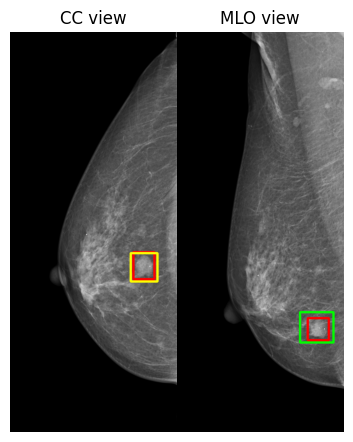

  0%|▊                                                                                                                                                                                                                                                                                 | 6/2000 [00:15<1:15:48,  2.28s/it]

True


  0%|▉                                                                                                                                                                                                                                                                                 | 7/2000 [00:17<1:12:53,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|█                                                                                                                                                                                                                                                                                 | 8/2000 [00:19<1:09:18,  2.09s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|█▏                                                                                                                                                                                                                                                                                | 9/2000 [00:21<1:08:37,  2.07s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|█▎                                                                                                                                                                                                                                                                               | 10/2000 [00:23<1:07:22,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▌                                                                                                                                                                                                                                                                               | 11/2000 [00:25<1:07:24,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▋                                                                                                                                                                                                                                                                               | 12/2000 [00:27<1:06:50,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▊                                                                                                                                                                                                                                                                               | 13/2000 [00:29<1:06:45,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▉                                                                                                                                                                                                                                                                               | 14/2000 [00:31<1:06:47,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██                                                                                                                                                                                                                                                                               | 15/2000 [00:33<1:06:47,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▏                                                                                                                                                                                                                                                                              | 16/2000 [00:35<1:06:27,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([108])
tensor([[350.2746, 888.6401, 401.4745, 930.8549]])


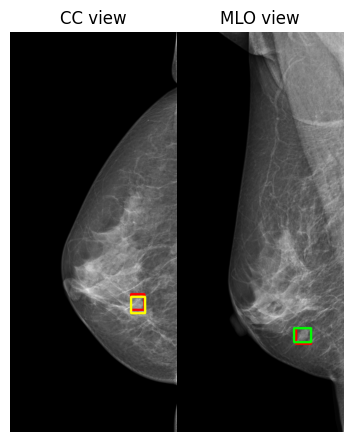

  1%|██▎                                                                                                                                                                                                                                                                              | 17/2000 [00:37<1:08:44,  2.08s/it]

True


  1%|██▍                                                                                                                                                                                                                                                                              | 18/2000 [00:39<1:07:30,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▌                                                                                                                                                                                                                                                                              | 19/2000 [00:41<1:06:35,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▋                                                                                                                                                                                                                                                                              | 20/2000 [00:43<1:06:10,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▊                                                                                                                                                                                                                                                                              | 21/2000 [00:45<1:05:42,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|███                                                                                                                                                                                                                                                                              | 22/2000 [00:47<1:05:40,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|███▏                                                                                                                                                                                                                                                                             | 23/2000 [00:49<1:05:11,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|███▎                                                                                                                                                                                                                                                                             | 24/2000 [00:51<1:05:29,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|███▍                                                                                                                                                                                                                                                                             | 25/2000 [00:53<1:05:26,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|███▌                                                                                                                                                                                                                                                                             | 26/2000 [00:55<1:04:53,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|███▋                                                                                                                                                                                                                                                                             | 27/2000 [00:57<1:04:44,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|███▊                                                                                                                                                                                                                                                                             | 28/2000 [00:59<1:05:05,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([1])
tensor([[197.4958, 496.1779, 247.8402, 552.3737]])


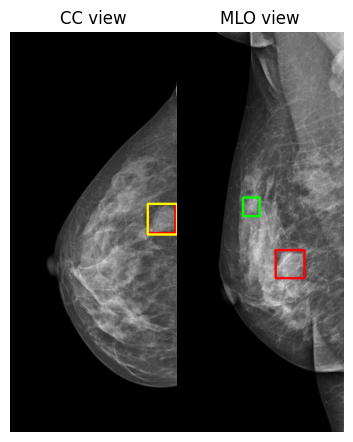

  1%|███▉                                                                                                                                                                                                                                                                             | 29/2000 [01:01<1:09:07,  2.10s/it]

True


  2%|████                                                                                                                                                                                                                                                                             | 30/2000 [01:03<1:07:58,  2.07s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[206.7269, 776.0632, 275.3202, 847.5444]])


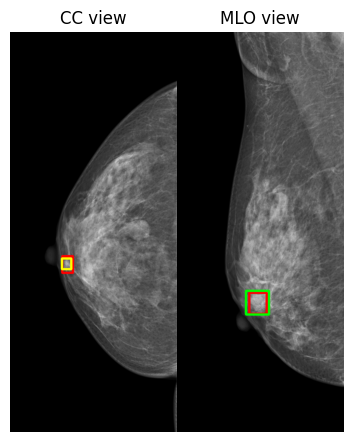

  2%|████▏                                                                                                                                                                                                                                                                            | 31/2000 [01:05<1:09:45,  2.13s/it]

True


  2%|████▎                                                                                                                                                                                                                                                                            | 32/2000 [01:07<1:08:39,  2.09s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▌                                                                                                                                                                                                                                                                            | 33/2000 [01:09<1:07:28,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▋                                                                                                                                                                                                                                                                            | 34/2000 [01:11<1:07:25,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▊                                                                                                                                                                                                                                                                            | 35/2000 [01:13<1:06:42,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▉                                                                                                                                                                                                                                                                            | 36/2000 [01:15<1:06:01,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|█████                                                                                                                                                                                                                                                                            | 37/2000 [01:17<1:05:03,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|█████▏                                                                                                                                                                                                                                                                           | 38/2000 [01:19<1:04:58,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|█████▎                                                                                                                                                                                                                                                                           | 39/2000 [01:21<1:05:00,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|█████▍                                                                                                                                                                                                                                                                           | 40/2000 [01:23<1:05:01,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|█████▌                                                                                                                                                                                                                                                                           | 41/2000 [01:25<1:04:30,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|█████▋                                                                                                                                                                                                                                                                           | 42/2000 [01:27<1:04:28,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|█████▊                                                                                                                                                                                                                                                                           | 43/2000 [01:29<1:04:15,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|██████                                                                                                                                                                                                                                                                           | 44/2000 [01:31<1:05:04,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|██████▏                                                                                                                                                                                                                                                                          | 45/2000 [01:33<1:04:23,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|██████▎                                                                                                                                                                                                                                                                          | 46/2000 [01:35<1:04:29,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|██████▍                                                                                                                                                                                                                                                                          | 47/2000 [01:37<1:04:31,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|██████▌                                                                                                                                                                                                                                                                          | 48/2000 [01:39<1:04:42,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|██████▋                                                                                                                                                                                                                                                                          | 49/2000 [01:41<1:04:08,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([6.0183e-05], grad_fn=<TopkBackward0>)
tensor([1])
tensor([[228.6424, 746.7599, 272.7260, 792.4771]])


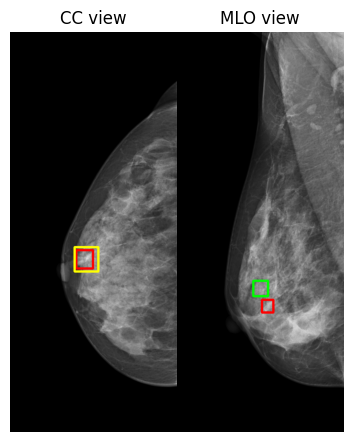

  2%|██████▊                                                                                                                                                                                                                                                                          | 50/2000 [01:43<1:06:44,  2.05s/it]

True


  3%|██████▉                                                                                                                                                                                                                                                                          | 51/2000 [01:45<1:06:27,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|███████                                                                                                                                                                                                                                                                          | 52/2000 [01:47<1:05:28,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|███████▏                                                                                                                                                                                                                                                                         | 53/2000 [01:49<1:05:12,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|███████▎                                                                                                                                                                                                                                                                         | 54/2000 [01:51<1:06:11,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|███████▌                                                                                                                                                                                                                                                                         | 55/2000 [01:53<1:05:52,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|███████▋                                                                                                                                                                                                                                                                         | 56/2000 [01:55<1:05:41,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|███████▊                                                                                                                                                                                                                                                                         | 57/2000 [01:57<1:05:46,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|███████▉                                                                                                                                                                                                                                                                         | 58/2000 [01:59<1:05:04,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|████████                                                                                                                                                                                                                                                                         | 59/2000 [02:01<1:05:13,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|████████▏                                                                                                                                                                                                                                                                        | 60/2000 [02:03<1:05:10,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|████████▎                                                                                                                                                                                                                                                                        | 61/2000 [02:05<1:05:01,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|████████▍                                                                                                                                                                                                                                                                        | 62/2000 [02:07<1:03:49,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|████████▌                                                                                                                                                                                                                                                                        | 63/2000 [02:09<1:04:21,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|████████▋                                                                                                                                                                                                                                                                        | 64/2000 [02:11<1:04:46,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|████████▊                                                                                                                                                                                                                                                                        | 65/2000 [02:13<1:04:56,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████████                                                                                                                                                                                                                                                                        | 66/2000 [02:15<1:04:46,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████████▏                                                                                                                                                                                                                                                                       | 67/2000 [02:17<1:03:57,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████████▎                                                                                                                                                                                                                                                                       | 68/2000 [02:19<1:03:05,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████████▍                                                                                                                                                                                                                                                                       | 69/2000 [02:21<1:03:26,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|█████████▌                                                                                                                                                                                                                                                                       | 70/2000 [02:23<1:02:35,  1.95s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|█████████▋                                                                                                                                                                                                                                                                       | 71/2000 [02:25<1:02:09,  1.93s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|█████████▊                                                                                                                                                                                                                                                                       | 72/2000 [02:27<1:02:43,  1.95s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|█████████▉                                                                                                                                                                                                                                                                       | 73/2000 [02:29<1:03:22,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████████                                                                                                                                                                                                                                                                       | 74/2000 [02:31<1:03:03,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████████▏                                                                                                                                                                                                                                                                      | 75/2000 [02:33<1:03:39,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████████▎                                                                                                                                                                                                                                                                      | 76/2000 [02:35<1:03:50,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████████▌                                                                                                                                                                                                                                                                      | 77/2000 [02:37<1:04:23,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████████▋                                                                                                                                                                                                                                                                      | 78/2000 [02:39<1:04:52,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████████▊                                                                                                                                                                                                                                                                      | 79/2000 [02:41<1:04:50,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████████▉                                                                                                                                                                                                                                                                      | 80/2000 [02:43<1:04:37,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([6.0640e-05], grad_fn=<TopkBackward0>)
tensor([178])
tensor([[304.4566,   0.0000, 500.0000, 329.2717]])


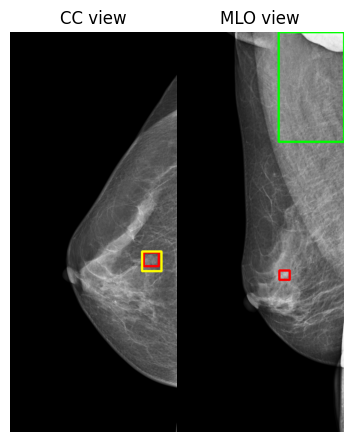

  4%|███████████                                                                                                                                                                                                                                                                      | 81/2000 [02:45<1:05:47,  2.06s/it]

True


  4%|███████████▏                                                                                                                                                                                                                                                                     | 82/2000 [02:47<1:05:24,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████████▎                                                                                                                                                                                                                                                                     | 83/2000 [02:49<1:05:05,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████████▍                                                                                                                                                                                                                                                                     | 84/2000 [02:51<1:05:09,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████████▌                                                                                                                                                                                                                                                                     | 85/2000 [02:53<1:04:04,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████████▋                                                                                                                                                                                                                                                                     | 86/2000 [02:55<1:03:49,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████████▉                                                                                                                                                                                                                                                                     | 87/2000 [02:57<1:03:36,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████████                                                                                                                                                                                                                                                                     | 88/2000 [02:59<1:03:52,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████████▏                                                                                                                                                                                                                                                                    | 89/2000 [03:01<1:03:55,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████████▎                                                                                                                                                                                                                                                                    | 90/2000 [03:03<1:04:14,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████████▍                                                                                                                                                                                                                                                                    | 91/2000 [03:05<1:03:41,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████████▌                                                                                                                                                                                                                                                                    | 92/2000 [03:07<1:03:55,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████████▋                                                                                                                                                                                                                                                                    | 93/2000 [03:09<1:03:40,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████████▊                                                                                                                                                                                                                                                                    | 94/2000 [03:11<1:04:48,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████████▉                                                                                                                                                                                                                                                                    | 95/2000 [03:14<1:05:52,  2.07s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████████                                                                                                                                                                                                                                                                    | 96/2000 [03:16<1:04:53,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████████▏                                                                                                                                                                                                                                                                   | 97/2000 [03:18<1:04:23,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████████▍                                                                                                                                                                                                                                                                   | 98/2000 [03:20<1:04:06,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████████▌                                                                                                                                                                                                                                                                   | 99/2000 [03:22<1:03:50,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████████▌                                                                                                                                                                                                                                                                  | 100/2000 [03:24<1:03:31,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████████▋                                                                                                                                                                                                                                                                  | 101/2000 [03:26<1:03:55,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████████▊                                                                                                                                                                                                                                                                  | 102/2000 [03:28<1:04:06,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████████                                                                                                                                                                                                                                                                  | 103/2000 [03:30<1:04:27,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████████▏                                                                                                                                                                                                                                                                 | 104/2000 [03:32<1:04:55,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████████▎                                                                                                                                                                                                                                                                 | 105/2000 [03:34<1:04:14,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████████▍                                                                                                                                                                                                                                                                 | 106/2000 [03:36<1:04:35,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████████▌                                                                                                                                                                                                                                                                 | 107/2000 [03:38<1:04:14,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████████▋                                                                                                                                                                                                                                                                 | 108/2000 [03:40<1:03:13,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████████▊                                                                                                                                                                                                                                                                 | 109/2000 [03:42<1:03:09,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|██████████████▉                                                                                                                                                                                                                                                                 | 110/2000 [03:44<1:03:27,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████████                                                                                                                                                                                                                                                                 | 111/2000 [03:46<1:03:23,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████████▏                                                                                                                                                                                                                                                                | 112/2000 [03:48<1:02:50,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████████▎                                                                                                                                                                                                                                                                | 113/2000 [03:50<1:02:59,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████████▌                                                                                                                                                                                                                                                                | 114/2000 [03:52<1:02:45,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████████▋                                                                                                                                                                                                                                                                | 115/2000 [03:54<1:03:04,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████████▊                                                                                                                                                                                                                                                                | 116/2000 [03:56<1:02:58,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████████▉                                                                                                                                                                                                                                                                | 117/2000 [03:58<1:03:12,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████████                                                                                                                                                                                                                                                                | 118/2000 [04:00<1:02:25,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████████▏                                                                                                                                                                                                                                                               | 119/2000 [04:02<1:02:33,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████████▎                                                                                                                                                                                                                                                               | 120/2000 [04:04<1:02:09,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████████▍                                                                                                                                                                                                                                                               | 121/2000 [04:06<1:02:13,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████████▌                                                                                                                                                                                                                                                               | 122/2000 [04:08<1:02:56,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████████▋                                                                                                                                                                                                                                                               | 123/2000 [04:10<1:02:58,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████████▊                                                                                                                                                                                                                                                               | 124/2000 [04:12<1:02:36,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|█████████████████                                                                                                                                                                                                                                                               | 125/2000 [04:14<1:02:05,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|█████████████████▏                                                                                                                                                                                                                                                              | 126/2000 [04:16<1:01:55,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|█████████████████▎                                                                                                                                                                                                                                                              | 127/2000 [04:18<1:01:57,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0007], grad_fn=<TopkBackward0>)
tensor([3])
tensor([[273.3308, 551.2492, 394.8383, 686.2955]])


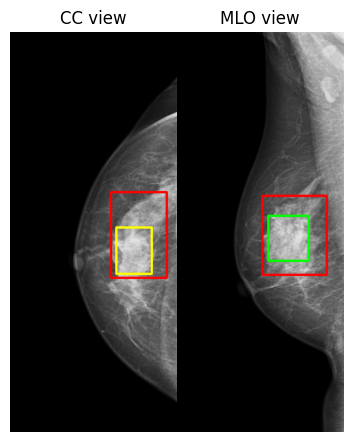

  6%|█████████████████▍                                                                                                                                                                                                                                                              | 128/2000 [04:20<1:03:55,  2.05s/it]

True


  6%|█████████████████▌                                                                                                                                                                                                                                                              | 129/2000 [04:22<1:03:31,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0003], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[371.8788, 871.0047, 466.3697, 965.2431]])


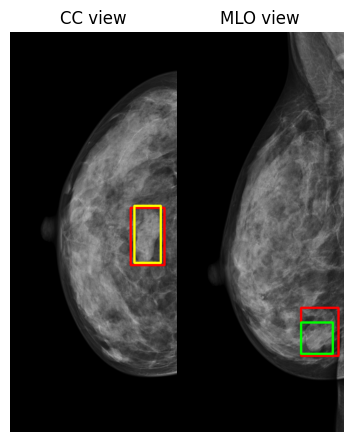

  6%|█████████████████▋                                                                                                                                                                                                                                                              | 130/2000 [04:24<1:05:11,  2.09s/it]

True


  7%|█████████████████▊                                                                                                                                                                                                                                                              | 131/2000 [04:26<1:03:30,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████████▉                                                                                                                                                                                                                                                              | 132/2000 [04:28<1:02:45,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████████                                                                                                                                                                                                                                                              | 133/2000 [04:30<1:02:24,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████████▏                                                                                                                                                                                                                                                             | 134/2000 [04:32<1:02:14,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████████▎                                                                                                                                                                                                                                                             | 135/2000 [04:34<1:02:15,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████████▍                                                                                                                                                                                                                                                             | 136/2000 [04:36<1:02:07,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[185.0630, 541.8310, 251.5223, 621.0787]])


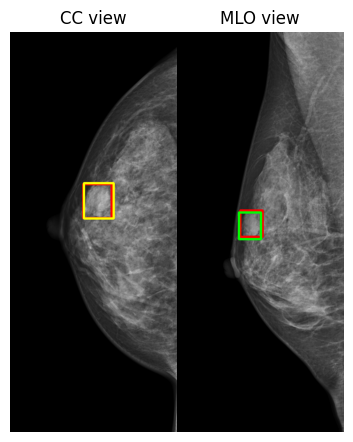

  7%|██████████████████▋                                                                                                                                                                                                                                                             | 137/2000 [04:38<1:04:21,  2.07s/it]

True


  7%|██████████████████▊                                                                                                                                                                                                                                                             | 138/2000 [04:40<1:03:54,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████████▉                                                                                                                                                                                                                                                             | 139/2000 [04:42<1:02:34,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|███████████████████                                                                                                                                                                                                                                                             | 140/2000 [04:44<1:02:11,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|███████████████████▏                                                                                                                                                                                                                                                            | 141/2000 [04:46<1:02:07,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|███████████████████▎                                                                                                                                                                                                                                                            | 142/2000 [04:48<1:02:19,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|███████████████████▍                                                                                                                                                                                                                                                            | 143/2000 [04:50<1:02:15,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|███████████████████▌                                                                                                                                                                                                                                                            | 144/2000 [04:52<1:02:39,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0001], grad_fn=<TopkBackward0>)
tensor([17])
tensor([[198.9678, 531.7825, 226.5523, 565.0928]])


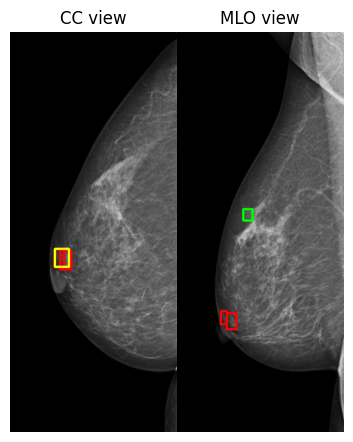

torch.Size([8, 1000, 1000])
tensor([0.0001], grad_fn=<TopkBackward0>)
tensor([17])
tensor([[198.9678, 531.7825, 226.5523, 565.0928]])


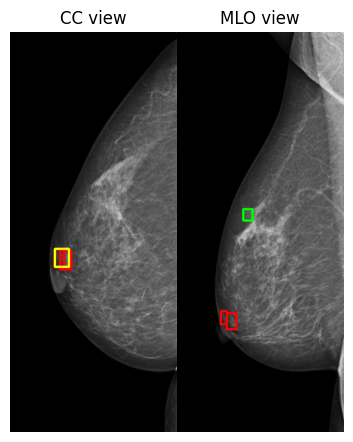

  7%|███████████████████▋                                                                                                                                                                                                                                                            | 145/2000 [04:55<1:06:30,  2.15s/it]

True


  7%|███████████████████▊                                                                                                                                                                                                                                                            | 146/2000 [04:57<1:05:29,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|███████████████████▉                                                                                                                                                                                                                                                            | 147/2000 [04:59<1:04:24,  2.09s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|████████████████████▏                                                                                                                                                                                                                                                           | 148/2000 [05:01<1:03:28,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|████████████████████▎                                                                                                                                                                                                                                                           | 149/2000 [05:03<1:02:26,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████████▍                                                                                                                                                                                                                                                           | 150/2000 [05:05<1:02:08,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████████▌                                                                                                                                                                                                                                                           | 151/2000 [05:07<1:01:46,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████████▋                                                                                                                                                                                                                                                           | 152/2000 [05:09<1:02:02,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████████▊                                                                                                                                                                                                                                                           | 153/2000 [05:11<1:01:37,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████████▉                                                                                                                                                                                                                                                           | 154/2000 [05:13<1:01:21,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|█████████████████████                                                                                                                                                                                                                                                           | 155/2000 [05:15<1:01:01,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|█████████████████████▏                                                                                                                                                                                                                                                          | 156/2000 [05:17<1:01:31,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|█████████████████████▎                                                                                                                                                                                                                                                          | 157/2000 [05:19<1:01:03,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|█████████████████████▍                                                                                                                                                                                                                                                          | 158/2000 [05:21<1:00:55,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|█████████████████████▊                                                                                                                                                                                                                                                            | 159/2000 [05:23<59:59,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|█████████████████████▊                                                                                                                                                                                                                                                          | 160/2000 [05:24<1:00:04,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|█████████████████████▉                                                                                                                                                                                                                                                          | 161/2000 [05:26<1:00:34,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████                                                                                                                                                                                                                                                          | 162/2000 [05:29<1:00:50,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████▏                                                                                                                                                                                                                                                         | 163/2000 [05:31<1:00:59,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████▎                                                                                                                                                                                                                                                         | 164/2000 [05:33<1:01:04,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████▍                                                                                                                                                                                                                                                         | 165/2000 [05:35<1:01:14,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████▌                                                                                                                                                                                                                                                         | 166/2000 [05:37<1:01:28,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████▋                                                                                                                                                                                                                                                         | 167/2000 [05:39<1:01:05,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████▊                                                                                                                                                                                                                                                         | 168/2000 [05:41<1:00:49,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████████████▉                                                                                                                                                                                                                                                         | 169/2000 [05:43<1:00:54,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████████████                                                                                                                                                                                                                                                         | 170/2000 [05:45<1:01:25,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0002], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[187.0583, 680.9843, 335.9139, 830.5888]])


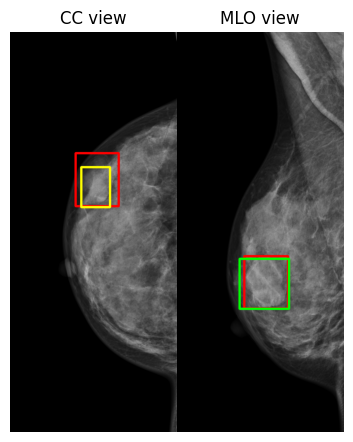

  9%|███████████████████████▎                                                                                                                                                                                                                                                        | 171/2000 [05:47<1:03:19,  2.08s/it]

True


  9%|███████████████████████▍                                                                                                                                                                                                                                                        | 172/2000 [05:49<1:02:38,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|███████████████████████▌                                                                                                                                                                                                                                                        | 173/2000 [05:51<1:02:03,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|███████████████████████▋                                                                                                                                                                                                                                                        | 174/2000 [05:53<1:02:12,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0006], grad_fn=<TopkBackward0>)
tensor([71])
tensor([[437.4244, 710.3424, 485.8805, 758.4232]])


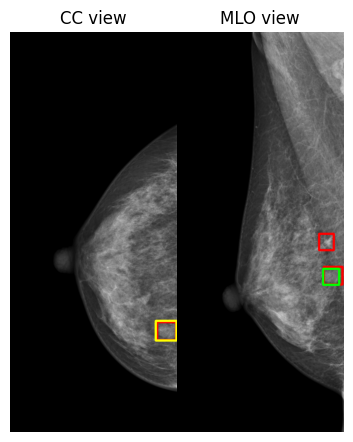

  9%|███████████████████████▊                                                                                                                                                                                                                                                        | 175/2000 [05:55<1:03:49,  2.10s/it]

True


  9%|███████████████████████▉                                                                                                                                                                                                                                                        | 176/2000 [05:57<1:03:08,  2.08s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████████████                                                                                                                                                                                                                                                        | 177/2000 [05:59<1:01:53,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████████████▏                                                                                                                                                                                                                                                       | 178/2000 [06:01<1:02:00,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████████████▎                                                                                                                                                                                                                                                       | 179/2000 [06:03<1:02:05,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████████████▍                                                                                                                                                                                                                                                       | 180/2000 [06:05<1:00:53,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████████████▌                                                                                                                                                                                                                                                       | 181/2000 [06:07<1:00:43,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████████████▊                                                                                                                                                                                                                                                       | 182/2000 [06:09<1:00:57,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0006], grad_fn=<TopkBackward0>)
tensor([59])
tensor([[346.2254, 493.0349, 375.7909, 544.1316]])


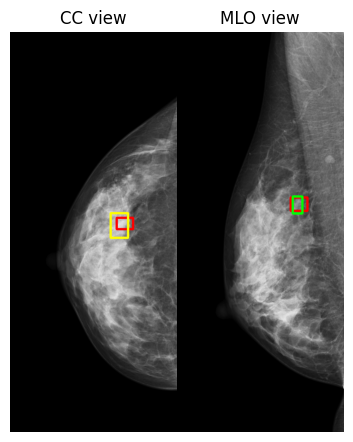

  9%|████████████████████████▉                                                                                                                                                                                                                                                       | 183/2000 [06:11<1:03:12,  2.09s/it]

True


  9%|█████████████████████████                                                                                                                                                                                                                                                       | 184/2000 [06:13<1:02:49,  2.08s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████████████▏                                                                                                                                                                                                                                                      | 185/2000 [06:15<1:00:54,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████████████▎                                                                                                                                                                                                                                                      | 186/2000 [06:17<1:00:37,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████████████▍                                                                                                                                                                                                                                                      | 187/2000 [06:19<1:00:31,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████████████▌                                                                                                                                                                                                                                                      | 188/2000 [06:21<1:00:42,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████████████▉                                                                                                                                                                                                                                                        | 189/2000 [06:23<59:44,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|█████████████████████████▊                                                                                                                                                                                                                                                      | 190/2000 [06:25<1:00:03,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([5])
tensor([[393.1754, 690.7278, 500.0000, 827.8685]])


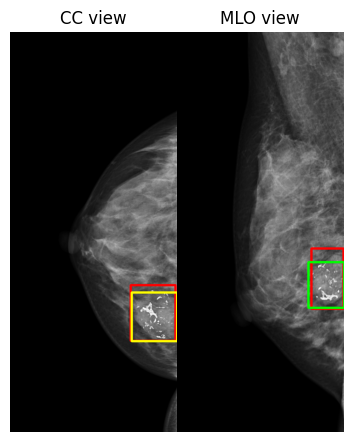

 10%|█████████████████████████▉                                                                                                                                                                                                                                                      | 191/2000 [06:28<1:02:59,  2.09s/it]

True


 10%|██████████████████████████                                                                                                                                                                                                                                                      | 192/2000 [06:29<1:01:45,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████████████▏                                                                                                                                                                                                                                                     | 193/2000 [06:31<1:00:49,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████████████▍                                                                                                                                                                                                                                                     | 194/2000 [06:33<1:00:41,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████████████▋                                                                                                                                                                                                                                                       | 195/2000 [06:35<59:58,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████████████▊                                                                                                                                                                                                                                                       | 196/2000 [06:37<59:18,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████████████▉                                                                                                                                                                                                                                                       | 197/2000 [06:39<59:40,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████████████▏                                                                                                                                                                                                                                                      | 198/2000 [06:41<59:29,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████████████▎                                                                                                                                                                                                                                                      | 199/2000 [06:43<59:18,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████████████▍                                                                                                                                                                                                                                                      | 200/2000 [06:45<59:31,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████████████▌                                                                                                                                                                                                                                                      | 201/2000 [06:47<59:27,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████████████▋                                                                                                                                                                                                                                                      | 202/2000 [06:49<59:38,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████████████▊                                                                                                                                                                                                                                                      | 203/2000 [06:51<59:51,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0003], grad_fn=<TopkBackward0>)
tensor([2])
tensor([[387.3792, 754.8284, 440.6387, 813.1935]])


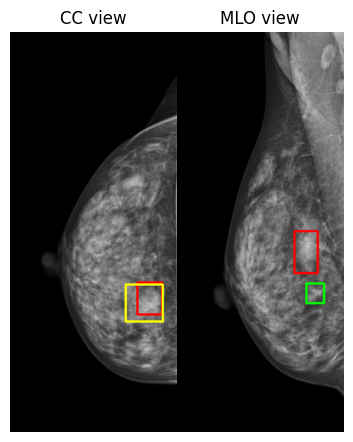

 10%|███████████████████████████▋                                                                                                                                                                                                                                                    | 204/2000 [06:53<1:01:31,  2.06s/it]

True


 10%|███████████████████████████▉                                                                                                                                                                                                                                                    | 205/2000 [06:55<1:01:10,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([20])
tensor([[248.3017, 623.5297, 360.1545, 700.9525]])


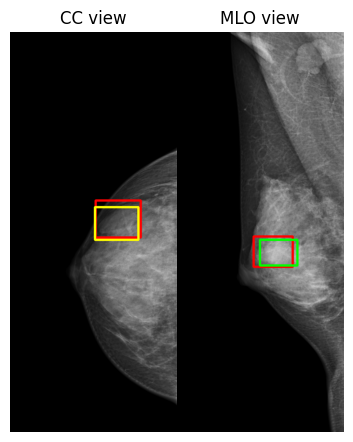

 10%|████████████████████████████                                                                                                                                                                                                                                                    | 206/2000 [06:58<1:03:26,  2.12s/it]

True


 10%|████████████████████████████▏                                                                                                                                                                                                                                                   | 207/2000 [07:00<1:02:15,  2.08s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|████████████████████████████▎                                                                                                                                                                                                                                                   | 208/2000 [07:02<1:00:25,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|████████████████████████████▋                                                                                                                                                                                                                                                     | 209/2000 [07:04<59:42,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|████████████████████████████▊                                                                                                                                                                                                                                                     | 210/2000 [07:06<59:37,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████████████▋                                                                                                                                                                                                                                                   | 211/2000 [07:08<1:00:08,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████████████▊                                                                                                                                                                                                                                                   | 212/2000 [07:10<1:00:28,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████████████▉                                                                                                                                                                                                                                                   | 213/2000 [07:12<1:00:05,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████████████▎                                                                                                                                                                                                                                                    | 214/2000 [07:14<59:53,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████████████▍                                                                                                                                                                                                                                                    | 215/2000 [07:16<59:44,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████████████▌                                                                                                                                                                                                                                                    | 216/2000 [07:18<59:00,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████████████▋                                                                                                                                                                                                                                                    | 217/2000 [07:20<59:11,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████████████▊                                                                                                                                                                                                                                                    | 218/2000 [07:22<59:22,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████                                                                                                                                                                                                                                                    | 219/2000 [07:24<59:03,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████▏                                                                                                                                                                                                                                                   | 220/2000 [07:26<58:56,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████▎                                                                                                                                                                                                                                                   | 221/2000 [07:28<58:13,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████▍                                                                                                                                                                                                                                                   | 222/2000 [07:30<58:33,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████▌                                                                                                                                                                                                                                                   | 223/2000 [07:31<58:19,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████▋                                                                                                                                                                                                                                                   | 224/2000 [07:33<58:26,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████▊                                                                                                                                                                                                                                                   | 225/2000 [07:35<58:06,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|██████████████████████████████▉                                                                                                                                                                                                                                                   | 226/2000 [07:37<57:59,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|███████████████████████████████                                                                                                                                                                                                                                                   | 227/2000 [07:39<58:35,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|███████████████████████████████▏                                                                                                                                                                                                                                                  | 228/2000 [07:41<58:25,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|███████████████████████████████▎                                                                                                                                                                                                                                                  | 229/2000 [07:43<58:33,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0008], grad_fn=<TopkBackward0>)
tensor([19])
tensor([[186.7746, 663.4683, 285.9864, 730.4350]])


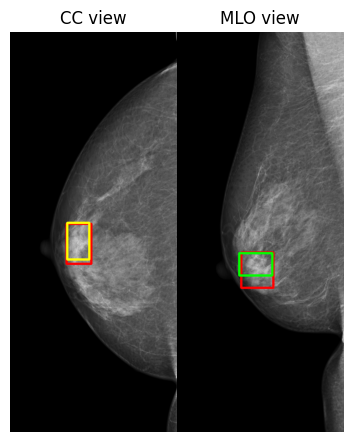

 12%|███████████████████████████████▎                                                                                                                                                                                                                                                | 230/2000 [07:46<1:00:38,  2.06s/it]

True


 12%|███████████████████████████████▍                                                                                                                                                                                                                                                | 231/2000 [07:48<1:00:00,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████████████▊                                                                                                                                                                                                                                                  | 232/2000 [07:50<59:34,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████████████▉                                                                                                                                                                                                                                                  | 233/2000 [07:52<59:27,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|████████████████████████████████                                                                                                                                                                                                                                                  | 234/2000 [07:54<59:02,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([11])
tensor([[127.3857, 637.4681, 211.3917, 692.0964]])


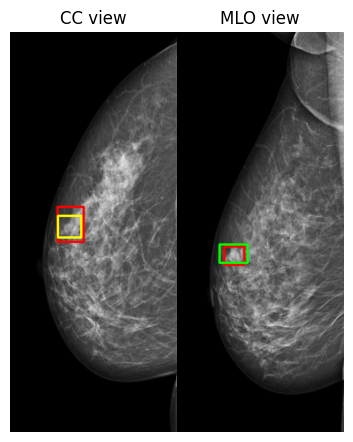

 12%|███████████████████████████████▉                                                                                                                                                                                                                                                | 235/2000 [07:56<1:01:12,  2.08s/it]

True


 12%|████████████████████████████████                                                                                                                                                                                                                                                | 236/2000 [07:58<1:00:12,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|████████████████████████████████▍                                                                                                                                                                                                                                                 | 237/2000 [08:00<59:31,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|████████████████████████████████▌                                                                                                                                                                                                                                                 | 238/2000 [08:02<58:37,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|████████████████████████████████▋                                                                                                                                                                                                                                                 | 239/2000 [08:04<58:49,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|████████████████████████████████▉                                                                                                                                                                                                                                                 | 240/2000 [08:06<58:35,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████                                                                                                                                                                                                                                                 | 241/2000 [08:08<57:57,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████▏                                                                                                                                                                                                                                                | 242/2000 [08:10<58:45,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████▎                                                                                                                                                                                                                                                | 243/2000 [08:12<59:51,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████▏                                                                                                                                                                                                                                              | 244/2000 [08:14<1:00:26,  2.07s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████▎                                                                                                                                                                                                                                              | 245/2000 [08:16<1:00:31,  2.07s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████▍                                                                                                                                                                                                                                              | 246/2000 [08:18<1:00:06,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████▊                                                                                                                                                                                                                                                | 247/2000 [08:20<59:10,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|█████████████████████████████████▉                                                                                                                                                                                                                                                | 248/2000 [08:22<58:11,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0008], grad_fn=<TopkBackward0>)
tensor([2])
tensor([[180.3597, 465.4560, 343.3594, 639.5539]])


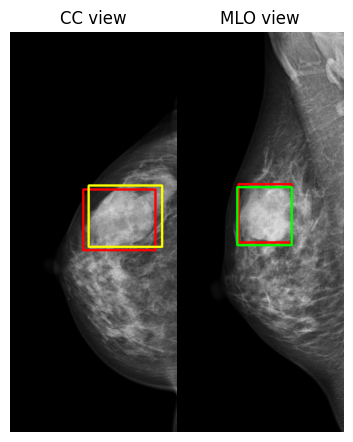

 12%|█████████████████████████████████▊                                                                                                                                                                                                                                              | 249/2000 [08:24<1:01:18,  2.10s/it]

True


 12%|██████████████████████████████████                                                                                                                                                                                                                                              | 250/2000 [08:26<1:00:23,  2.07s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|██████████████████████████████████▍                                                                                                                                                                                                                                               | 251/2000 [08:28<59:38,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|██████████████████████████████████▌                                                                                                                                                                                                                                               | 252/2000 [08:30<59:35,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|██████████████████████████████████▋                                                                                                                                                                                                                                               | 253/2000 [08:32<58:19,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|██████████████████████████████████▊                                                                                                                                                                                                                                               | 254/2000 [08:34<58:04,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|██████████████████████████████████▉                                                                                                                                                                                                                                               | 255/2000 [08:36<57:48,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|███████████████████████████████████                                                                                                                                                                                                                                               | 256/2000 [08:38<58:02,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|███████████████████████████████████▏                                                                                                                                                                                                                                              | 257/2000 [08:40<58:01,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|███████████████████████████████████▎                                                                                                                                                                                                                                              | 258/2000 [08:42<58:11,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|███████████████████████████████████▍                                                                                                                                                                                                                                              | 259/2000 [08:44<57:58,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|███████████████████████████████████▌                                                                                                                                                                                                                                              | 260/2000 [08:46<58:26,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|███████████████████████████████████▊                                                                                                                                                                                                                                              | 261/2000 [08:48<58:05,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|███████████████████████████████████▉                                                                                                                                                                                                                                              | 262/2000 [08:50<58:15,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████████████████                                                                                                                                                                                                                                              | 263/2000 [08:52<58:03,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████████████████▏                                                                                                                                                                                                                                             | 264/2000 [08:54<58:25,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████████████████▎                                                                                                                                                                                                                                             | 265/2000 [08:56<58:07,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████████████████▍                                                                                                                                                                                                                                             | 266/2000 [08:58<58:36,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████████████████▌                                                                                                                                                                                                                                             | 267/2000 [09:00<58:06,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████████████████▋                                                                                                                                                                                                                                             | 268/2000 [09:02<57:59,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████████████████▊                                                                                                                                                                                                                                             | 269/2000 [09:04<56:51,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|████████████████████████████████████▉                                                                                                                                                                                                                                             | 270/2000 [09:06<57:18,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████████████████▏                                                                                                                                                                                                                                            | 271/2000 [09:08<57:34,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████████████████▎                                                                                                                                                                                                                                            | 272/2000 [09:10<57:46,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████████████████▍                                                                                                                                                                                                                                            | 273/2000 [09:12<56:57,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████████████████▌                                                                                                                                                                                                                                            | 274/2000 [09:14<56:57,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████████████████▋                                                                                                                                                                                                                                            | 275/2000 [09:16<57:10,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████████████████▊                                                                                                                                                                                                                                            | 276/2000 [09:18<57:19,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████████████████▉                                                                                                                                                                                                                                            | 277/2000 [09:20<56:26,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████████████████                                                                                                                                                                                                                                            | 278/2000 [09:22<56:31,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████████████████▏                                                                                                                                                                                                                                           | 279/2000 [09:24<56:43,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████████████████▎                                                                                                                                                                                                                                           | 280/2000 [09:26<56:57,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████████████████▍                                                                                                                                                                                                                                           | 281/2000 [09:28<56:42,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████████████████▋                                                                                                                                                                                                                                           | 282/2000 [09:30<56:07,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████████████████▊                                                                                                                                                                                                                                           | 283/2000 [09:32<56:17,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████████████████▉                                                                                                                                                                                                                                           | 284/2000 [09:34<55:54,  1.95s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████████████████                                                                                                                                                                                                                                           | 285/2000 [09:36<56:13,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████████████████▏                                                                                                                                                                                                                                          | 286/2000 [09:38<55:50,  1.95s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████████████████▎                                                                                                                                                                                                                                          | 287/2000 [09:40<56:31,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████████████████▍                                                                                                                                                                                                                                          | 288/2000 [09:42<57:06,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████████████████▌                                                                                                                                                                                                                                          | 289/2000 [09:44<56:34,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████████████████▋                                                                                                                                                                                                                                          | 290/2000 [09:46<56:35,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|███████████████████████████████████████▊                                                                                                                                                                                                                                          | 291/2000 [09:48<56:41,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████                                                                                                                                                                                                                                          | 292/2000 [09:50<57:03,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████▏                                                                                                                                                                                                                                         | 293/2000 [09:52<57:05,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████▎                                                                                                                                                                                                                                         | 294/2000 [09:54<57:25,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████▍                                                                                                                                                                                                                                         | 295/2000 [09:56<57:16,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                         | 296/2000 [09:58<57:26,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████▋                                                                                                                                                                                                                                         | 297/2000 [10:00<56:52,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████▊                                                                                                                                                                                                                                         | 298/2000 [10:02<56:59,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████████████████▉                                                                                                                                                                                                                                         | 299/2000 [10:04<56:46,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████████████████                                                                                                                                                                                                                                         | 300/2000 [10:06<56:49,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████████████████▏                                                                                                                                                                                                                                        | 301/2000 [10:08<57:03,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████████████████▎                                                                                                                                                                                                                                        | 302/2000 [10:10<57:11,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████████████████▌                                                                                                                                                                                                                                        | 303/2000 [10:12<57:19,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████████████████▋                                                                                                                                                                                                                                        | 304/2000 [10:14<56:51,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████████████████▊                                                                                                                                                                                                                                        | 305/2000 [10:16<56:19,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████████████████▉                                                                                                                                                                                                                                        | 306/2000 [10:18<56:30,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|██████████████████████████████████████████                                                                                                                                                                                                                                        | 307/2000 [10:20<56:49,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|██████████████████████████████████████████▏                                                                                                                                                                                                                                       | 308/2000 [10:22<56:39,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|██████████████████████████████████████████▎                                                                                                                                                                                                                                       | 309/2000 [10:24<56:38,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████████████████▍                                                                                                                                                                                                                                       | 310/2000 [10:26<56:47,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████████████████▌                                                                                                                                                                                                                                       | 311/2000 [10:28<56:42,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████████████████▋                                                                                                                                                                                                                                       | 312/2000 [10:30<56:46,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████████████████▉                                                                                                                                                                                                                                       | 313/2000 [10:32<56:32,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████                                                                                                                                                                                                                                       | 314/2000 [10:34<56:21,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████▏                                                                                                                                                                                                                                      | 315/2000 [10:36<56:07,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████▎                                                                                                                                                                                                                                      | 316/2000 [10:38<55:35,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████▍                                                                                                                                                                                                                                      | 317/2000 [10:40<55:17,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████▌                                                                                                                                                                                                                                      | 318/2000 [10:42<55:46,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                      | 319/2000 [10:44<55:40,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████▊                                                                                                                                                                                                                                      | 320/2000 [10:46<55:32,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████████████████▉                                                                                                                                                                                                                                      | 321/2000 [10:48<55:53,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|████████████████████████████████████████████                                                                                                                                                                                                                                      | 322/2000 [10:50<56:36,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 323/2000 [10:52<56:12,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0003], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[339.9286, 699.3393, 492.2008, 850.2424]])


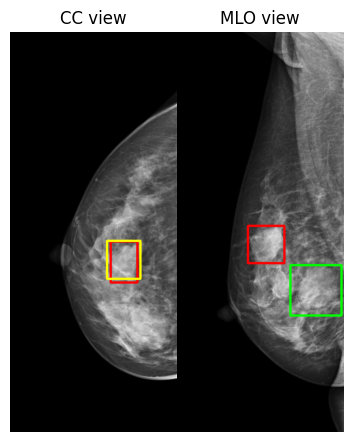

 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                     | 324/2000 [10:54<58:30,  2.09s/it]

True


 16%|████████████████████████████████████████████▌                                                                                                                                                                                                                                     | 325/2000 [10:56<57:31,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([40])
tensor([[316.6934, 662.5341, 360.0765, 711.9562]])


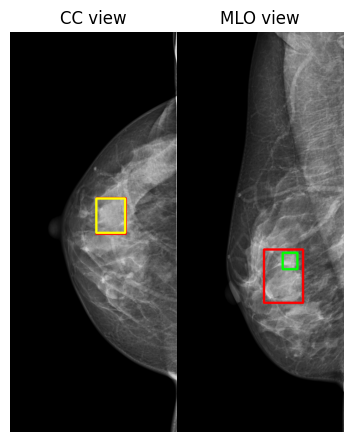

 16%|████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 326/2000 [10:59<59:03,  2.12s/it]

True


 16%|████████████████████████████████████████████▊                                                                                                                                                                                                                                     | 327/2000 [11:01<58:44,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|████████████████████████████████████████████▉                                                                                                                                                                                                                                     | 328/2000 [11:03<57:35,  2.07s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|█████████████████████████████████████████████                                                                                                                                                                                                                                     | 329/2000 [11:05<56:31,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                    | 330/2000 [11:07<56:13,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 331/2000 [11:09<56:01,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████████████████▍                                                                                                                                                                                                                                    | 332/2000 [11:11<55:42,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 333/2000 [11:13<55:44,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 334/2000 [11:14<55:12,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████████████████▉                                                                                                                                                                                                                                    | 335/2000 [11:16<54:31,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████                                                                                                                                                                                                                                    | 336/2000 [11:18<54:30,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 337/2000 [11:20<54:22,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                   | 338/2000 [11:22<54:22,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 339/2000 [11:24<55:41,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████▌                                                                                                                                                                                                                                   | 340/2000 [11:26<55:33,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████▋                                                                                                                                                                                                                                   | 341/2000 [11:28<55:11,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████▊                                                                                                                                                                                                                                   | 342/2000 [11:30<54:49,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 343/2000 [11:32<55:24,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                  | 344/2000 [11:34<54:38,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([2])
tensor([[443.2004, 515.2593, 498.9722, 580.7953]])


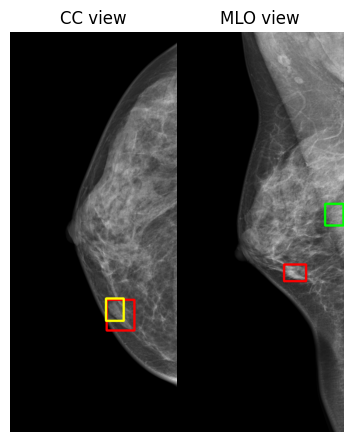

torch.Size([8, 1000, 1000])
tensor([2.7725e-05], grad_fn=<TopkBackward0>)
tensor([2])
tensor([[443.2004, 515.2593, 498.9722, 580.7953]])


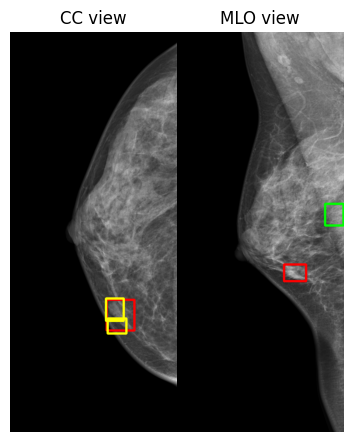

 17%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                  | 345/2000 [11:37<59:05,  2.14s/it]

True


 17%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 346/2000 [11:39<58:03,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|███████████████████████████████████████████████▌                                                                                                                                                                                                                                  | 347/2000 [11:41<57:10,  2.08s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([5])
tensor([[167.1616, 824.1326, 235.0291, 890.8345]])


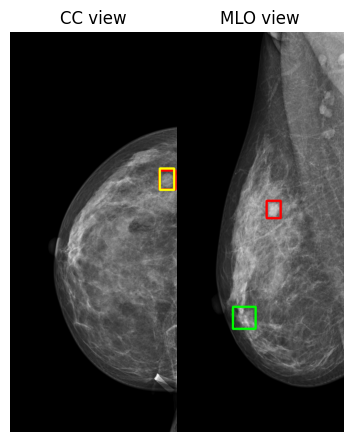

 17%|███████████████████████████████████████████████▋                                                                                                                                                                                                                                  | 348/2000 [11:43<58:20,  2.12s/it]

True


 17%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 349/2000 [11:45<57:25,  2.09s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 350/2000 [11:47<56:19,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|████████████████████████████████████████████████                                                                                                                                                                                                                                  | 351/2000 [11:49<55:29,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 352/2000 [11:51<54:43,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 353/2000 [11:53<54:23,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|████████████████████████████████████████████████▍                                                                                                                                                                                                                                 | 354/2000 [11:55<54:16,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 355/2000 [11:57<54:17,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                 | 356/2000 [11:59<53:54,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 357/2000 [12:01<54:11,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████████████████████                                                                                                                                                                                                                                 | 358/2000 [12:03<54:02,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 359/2000 [12:05<54:30,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████████████████████▎                                                                                                                                                                                                                                | 360/2000 [12:07<54:43,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████████████████████▍                                                                                                                                                                                                                                | 361/2000 [12:09<54:51,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████████████████████▌                                                                                                                                                                                                                                | 362/2000 [12:11<54:51,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 363/2000 [12:13<54:57,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████████████████████▊                                                                                                                                                                                                                                | 364/2000 [12:15<54:38,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0005], grad_fn=<TopkBackward0>)
tensor([129])
tensor([[287.7863, 677.6577, 387.0488, 848.6842]])


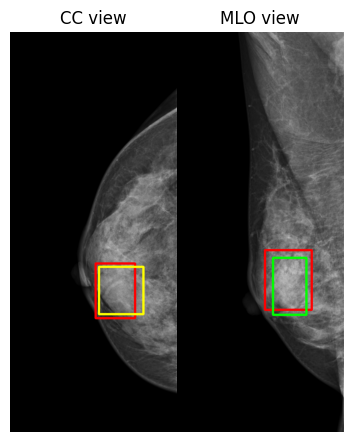

 18%|██████████████████████████████████████████████████                                                                                                                                                                                                                                | 365/2000 [12:17<56:28,  2.07s/it]

True


 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 366/2000 [12:19<55:35,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████████████████████▎                                                                                                                                                                                                                               | 367/2000 [12:21<54:50,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                               | 368/2000 [12:23<54:47,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 369/2000 [12:25<54:32,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                               | 370/2000 [12:27<54:04,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                               | 371/2000 [12:29<54:09,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|██████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 372/2000 [12:31<54:19,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████████████████████                                                                                                                                                                                                                               | 373/2000 [12:33<54:12,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████████████████████▏                                                                                                                                                                                                                              | 374/2000 [12:35<53:40,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 375/2000 [12:37<53:38,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████████████████████▌                                                                                                                                                                                                                              | 376/2000 [12:39<53:25,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████████████████████▋                                                                                                                                                                                                                              | 377/2000 [12:41<53:06,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████████████████████▊                                                                                                                                                                                                                              | 378/2000 [12:43<53:34,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 379/2000 [12:45<53:16,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████████████████████                                                                                                                                                                                                                              | 380/2000 [12:47<52:39,  1.95s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                             | 381/2000 [12:49<52:52,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 382/2000 [12:51<52:42,  1.95s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                             | 383/2000 [12:53<53:18,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 384/2000 [12:55<53:11,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████████████████████▋                                                                                                                                                                                                                             | 385/2000 [12:57<53:10,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████████████████████▉                                                                                                                                                                                                                             | 386/2000 [12:59<53:19,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████████████████████                                                                                                                                                                                                                             | 387/2000 [13:00<52:41,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 388/2000 [13:03<53:37,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                            | 389/2000 [13:05<54:00,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                                            | 390/2000 [13:07<53:14,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                            | 391/2000 [13:09<53:38,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 392/2000 [13:11<54:33,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                            | 393/2000 [13:13<55:13,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|█████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 394/2000 [13:15<54:32,  2.04s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████████████████████                                                                                                                                                                                                                            | 395/2000 [13:17<54:01,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████████████████████▎                                                                                                                                                                                                                           | 396/2000 [13:19<53:38,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                           | 397/2000 [13:21<53:42,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 398/2000 [13:23<53:18,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                                           | 399/2000 [13:25<53:58,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 400/2000 [13:27<53:45,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                                           | 401/2000 [13:29<53:06,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0012], grad_fn=<TopkBackward0>)
tensor([8])
tensor([[314.8710, 563.8282, 426.7130, 640.5142]])


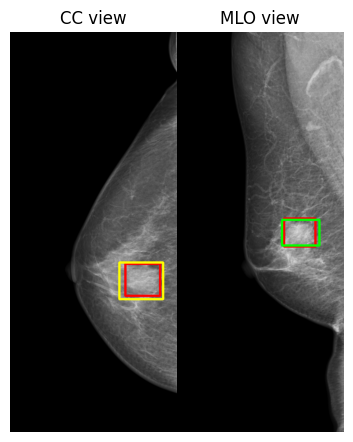

 20%|███████████████████████████████████████████████████████                                                                                                                                                                                                                           | 402/2000 [13:31<54:46,  2.06s/it]

True


 20%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                          | 403/2000 [13:33<53:58,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                                          | 404/2000 [13:35<53:17,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                                          | 405/2000 [13:37<53:29,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 406/2000 [13:39<53:07,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 407/2000 [13:41<53:05,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 408/2000 [13:43<53:02,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                          | 409/2000 [13:45<52:57,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 410/2000 [13:47<52:36,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                                         | 411/2000 [13:49<52:45,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 412/2000 [13:51<52:45,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                                         | 413/2000 [13:53<52:57,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████████████████████▋                                                                                                                                                                                                                         | 414/2000 [13:55<52:48,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 415/2000 [13:57<53:08,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 416/2000 [13:59<52:30,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                                        | 417/2000 [14:01<52:42,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 418/2000 [14:03<52:37,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                                                        | 419/2000 [14:05<52:31,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                                                        | 420/2000 [14:07<51:40,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                                        | 421/2000 [14:09<51:36,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 422/2000 [14:11<51:38,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0011], grad_fn=<TopkBackward0>)
tensor([73])
tensor([[201.8744, 411.1717, 313.0216, 653.0380]])


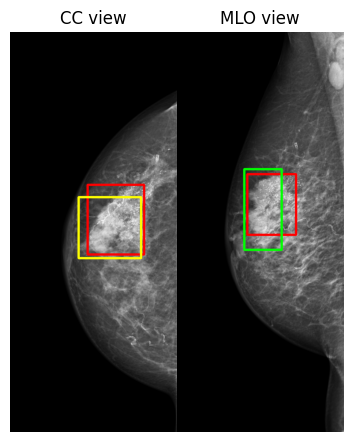

 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                        | 423/2000 [14:13<54:05,  2.06s/it]

True


 21%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                        | 424/2000 [14:15<52:57,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 425/2000 [14:17<52:41,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                                       | 426/2000 [14:19<52:28,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                       | 427/2000 [14:21<52:34,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 428/2000 [14:23<52:19,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                                                       | 429/2000 [14:25<52:25,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                                       | 430/2000 [14:27<52:13,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 431/2000 [14:29<51:27,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                      | 432/2000 [14:31<52:04,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                      | 433/2000 [14:33<52:12,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                                      | 434/2000 [14:35<52:30,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 435/2000 [14:37<52:28,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 436/2000 [14:39<51:40,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 437/2000 [14:41<51:39,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 438/2000 [14:43<51:24,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                     | 439/2000 [14:45<50:58,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                     | 440/2000 [14:47<51:03,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 441/2000 [14:49<50:59,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                     | 442/2000 [14:50<51:07,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                     | 443/2000 [14:52<51:19,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                     | 444/2000 [14:54<51:24,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 445/2000 [14:56<51:04,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|█████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 446/2000 [14:58<51:20,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                    | 447/2000 [15:00<51:44,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0005], grad_fn=<TopkBackward0>)
tensor([248])
tensor([[190.3098, 664.5142, 222.6152, 700.1179]])


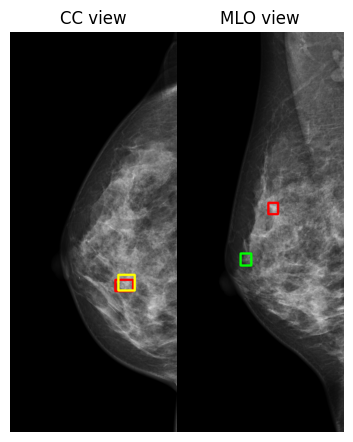

 22%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                    | 448/2000 [15:03<53:53,  2.08s/it]

True


 22%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                    | 449/2000 [15:05<53:14,  2.06s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 450/2000 [15:07<52:31,  2.03s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 451/2000 [15:09<52:00,  2.01s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                    | 452/2000 [15:11<51:31,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                                    | 453/2000 [15:13<51:20,  1.99s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                   | 454/2000 [15:15<50:54,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 455/2000 [15:17<50:52,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                   | 456/2000 [15:19<50:41,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 457/2000 [15:20<50:33,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 458/2000 [15:22<50:38,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                   | 459/2000 [15:24<50:51,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████                                                                                                                                                                                                                   | 460/2000 [15:26<50:47,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 461/2000 [15:28<50:53,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                  | 462/2000 [15:30<50:29,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 463/2000 [15:32<50:45,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                  | 464/2000 [15:34<50:10,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 465/2000 [15:36<49:50,  1.95s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 466/2000 [15:38<50:17,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                  | 467/2000 [15:40<50:38,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 468/2000 [15:42<50:20,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                 | 469/2000 [15:44<50:32,  1.98s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0007], grad_fn=<TopkBackward0>)
tensor([14])
tensor([[327.9715, 575.7812, 415.3431, 647.4552]])


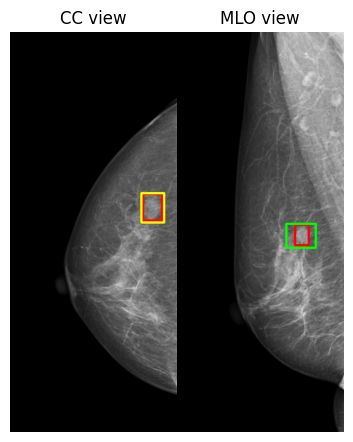

 24%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 470/2000 [15:46<52:41,  2.07s/it]

True


 24%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 471/2000 [15:48<52:07,  2.05s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                 | 472/2000 [15:50<51:32,  2.02s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                 | 473/2000 [15:52<50:57,  2.00s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 474/2000 [15:54<50:03,  1.97s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                 | 475/2000 [15:56<49:51,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                | 476/2000 [15:58<49:48,  1.96s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                | 476/2000 [16:00<51:15,  2.02s/it]


KeyboardInterrupt: 

In [7]:
device='cpu'
#model.roi_heads.score_thresh =0.01
for images_CC, images_MLO, targets_CC, targets_MLO in tqdm(valid_loader):
    images_CC = list(image_CC.to(device) for image_CC in images_CC)
    images_MLO = list(image_MLO.to(device) for image_MLO in images_MLO)
    #images = torch.stack(images)
    #print(images.shape)
    #images = images.to(device)
    targets_CC = [{k: v.to(device) for k, v in t.items()} for t in targets_CC]
    targets_MLO = [{k: v.to(device) for k, v in t.items()} for t in targets_MLO]

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    model_time = time.time()
    model.roi_heads.crossview.decoder.layers[0].train()
    print(model.roi_heads.crossview.decoder.layers[0][0].training)
    outputs_CC, outputs_MLO= model(images_CC, images_MLO, targets_CC, targets_MLO)
        #print('out',outputs)
        #print('tar',targets)
    #####################################
    for i in range(len(images_CC)):
        true_dict_CC = dict()
        true_dict_MLO = dict()
        preds_dict_CC = dict()
        preds_dict_MLO = dict()
        true_dict_CC['boxes'] = targets_CC[i]['boxes']
        true_dict_CC['labels'] = targets_CC[i]['labels']
        preds_dict_CC['boxes'] = outputs_CC[i]['boxes']
        preds_dict_CC['scores'] = outputs_CC[i]['scores']
        preds_dict_CC['labels'] = outputs_CC[i]['labels']
        
        true_dict_MLO['boxes'] = targets_MLO[i]['boxes']
        true_dict_MLO['labels'] = targets_MLO[i]['labels']
        preds_dict_MLO['boxes'] = outputs_MLO[i]['boxes']
        preds_dict_MLO['scores'] = outputs_MLO[i]['scores']
        preds_dict_MLO['labels'] = outputs_MLO[i]['labels']
        img_CC = images_CC[i]
        img_MLO = images_MLO[i]
        #img = invTrans(img)[0]
        img_CC= img_CC.permute(1,2,0)
        img_MLO = img_MLO.permute(1,2,0)
        img_CC = img_CC.cpu().numpy().copy()
        img_MLO = img_MLO.cpu().numpy().copy()
        for j in range(len(true_dict_CC['labels'])):
            x_min, y_min, x_max, y_max = true_dict_CC['boxes'][j]
            img_CC =cv2.rectangle(img=img_CC,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,0,0),thickness =5)
        for j in range(len(true_dict_MLO['labels'])):
            x_min, y_min, x_max, y_max = true_dict_MLO['boxes'][j]
            img_MLO =cv2.rectangle(img=img_MLO,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,0,0),thickness =5)
        for j in range(len(true_dict_CC['labels'])):
            for k in range(len(preds_dict_CC['labels'])):
                if true_dict_CC['labels'][j] == preds_dict_CC['labels'][k]:
                    pred_box= preds_dict_CC['boxes'][k].clone()
                    pred_box[2:] -= pred_box[:2]
                    true_box= true_dict_CC['boxes'][j].clone()
                    true_box[2:]-= true_box[:2]
                    iou_score= get_iou_score(true_box, pred_box)
                    if iou_score>0.2:
                        model.zero_grad()
                        #preds_dict_CC['scores'][i].backward(retain_graph=True)
                        print(model.roi_heads.crossview.decoder.layers[0][0].attn.shape)
                        grad=torch.autograd.grad(preds_dict_CC['scores'][k], [model.roi_heads.crossview.decoder.layers[0][0].attn], retain_graph=True)[0]
                        index_CC = model.roi_heads.index[i]["CC"][k]
                        cam = model.roi_heads.crossview.decoder.layers[0][0].attn
                        #print(model.roi_heads.crossview.decoder.layers[0][0].tgt2.grad)
                        #grad = model.roi_heads.crossview.decoder.layers[0][0].attn.grad
                        cam = grad*cam
                        cam = cam.clamp(min=0).mean(dim=0)
                        R =cam[index_CC]
                        value, indices = torch.topk(R, 1)
                        print(value)
                        print(indices)
                        print(model.roi_heads.proposals[i]['MLO'][indices])
                        x_min, y_min, x_max, y_max = preds_dict_CC['boxes'][k]
                        img_CC =cv2.rectangle(img=img_CC,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,1.0,0),thickness =5)
                        #score =preds_dict_CC['scores'][k]
                        #cv2.putText(img_CC, f'{score}', (int(x_min), int(y_min-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (1.0,1.0,0), 5)
                        for boxes_MLO in model.roi_heads.proposals[i]['MLO'][indices]:
                            x_min, y_min, x_max, y_max = boxes_MLO
                            img_MLO = cv2.rectangle(img=img_MLO,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (0,1.0,0),thickness =5)
                        aspect= 1200/500
                        n = 1 # number of rows
                        m = 2 # numberof columns
                        bottom = 0.1; left=0.05
                        top=1.-bottom; right = 1.-left
                        fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
                        #widthspace, relative to subplot size
                        wspace=0.  # set to zero for no spacing
                        hspace=wspace/float(aspect)
                        #fix the figure height
                        figheight= 5 # inch
                        figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp
                        fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
                        plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left,wspace=wspace, hspace=hspace) 
                        axs[0].imshow(img_CC)
                        axs[0].axis('off')
                        axs[0].set_title("CC view")
                        axs[1].imshow(img_MLO)
                        axs[1].axis('off')
                        axs[1].set_title("MLO view")
                        #plt.subplots_adjust(wspace=None, hspace=None)
                        plt.show()

In [ ]:
5 16 129 136 170 190


In [ ]:
np.linspace(0,1,10)

In [ ]:
img = np.zeros((100,100,3))
img =cv2.rectangle(img =img,pt1= (40,40),pt2= (80,80), color = (0,0,1.0),thickness =5)
plt.imshow(img)

In [ ]:
x=torch.ones(1000).cuda()
x.requires_grad=True
y= torch.ones(1000).cuda()
y.requires_grad=True
z=  (x*y).sum()
x= x.view(5,200)
x.retain_grad()
z.backward()

print(x.grad)

In [ ]:
torch.__version__

In [ ]:
x=1
f'{x}'

In [7]:
from datasets import create_valid_dataset_multi_mask
valid_dataset_mask = create_valid_dataset_multi_mask(
    VALID_DIR_IMAGES, 
    VALID_DIR_LABELS, 
    IMAGE_SIZE, 
    CLASSES,
    mask=True
)
valid_loader_mask = create_valid_loader(valid_dataset_mask, BATCH_SIZE, NUM_WORKERS)

1000
     index                          study_id  \
0        6  5683854eafabc34f6d854000d2ac6c2d   
1        7  5683854eafabc34f6d854000d2ac6c2d   
2       18  917a4de3b1f921f1c9fa98b7a61d749d   
3       19  917a4de3b1f921f1c9fa98b7a61d749d   
4       20  31fa226bc9f87e0a2cb2de6dddbc2270   
..     ...                               ...   
332   2246  b8acac150be7f949f78dc631a3851f8b   
333   2247  b8acac150be7f949f78dc631a3851f8b   
334   2249  b8acac150be7f949f78dc631a3851f8b   
335   2250  b8acac150be7f949f78dc631a3851f8b   
336   2251  b8acac150be7f949f78dc631a3851f8b   

                             image_id  height  width         xmin  \
0    2f944efb1cb9579442df2d7fe6a579b7    3518   2800   142.899002   
1    7385e8cf7b29764525c81de4aa1aebe4    3518   2800   142.899002   
2    4dd8faf113a9421e03a6e2bcd4238da2    3518   2800   153.445999   
3    19056b152c5d2ed98f66de006fa45a6c    3518   2800   141.677002   
4    625aa350502a7038cfe5f9ca5f1a65f4    3518   2800   192.143005   
..  

  0%|                                                                                                                                                                                                            | 0/2000 [00:00<?, ?it/s]

True


  0%|                                                                                                                                                                                                  | 1/2000 [00:05<3:09:39,  5.69s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▏                                                                                                                                                                                                 | 2/2000 [00:08<2:07:41,  3.83s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▎                                                                                                                                                                                                 | 3/2000 [00:10<1:40:40,  3.02s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▍                                                                                                                                                                                                 | 4/2000 [00:12<1:30:14,  2.71s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▍                                                                                                                                                                                                 | 5/2000 [00:14<1:21:55,  2.46s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0001], grad_fn=<TopkBackward0>)
tensor([43])
tensor([[406.3918, 698.2404, 436.5826, 725.4745]])


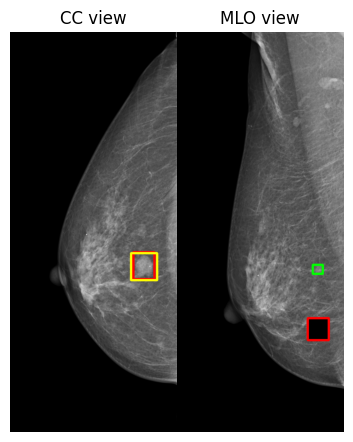

  0%|▌                                                                                                                                                                                                 | 6/2000 [00:16<1:21:24,  2.45s/it]

True


  0%|▋                                                                                                                                                                                                 | 7/2000 [00:19<1:19:50,  2.40s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▊                                                                                                                                                                                                 | 8/2000 [00:21<1:18:20,  2.36s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▊                                                                                                                                                                                                 | 9/2000 [00:23<1:16:31,  2.31s/it]

torch.Size([1000])
torch.Size([1000])
True


  0%|▉                                                                                                                                                                                                | 10/2000 [00:26<1:16:16,  2.30s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█                                                                                                                                                                                                | 11/2000 [00:28<1:14:32,  2.25s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▏                                                                                                                                                                                               | 12/2000 [00:30<1:14:17,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▎                                                                                                                                                                                               | 13/2000 [00:32<1:13:16,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▎                                                                                                                                                                                               | 14/2000 [00:34<1:13:45,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▍                                                                                                                                                                                               | 15/2000 [00:36<1:13:35,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▌                                                                                                                                                                                               | 16/2000 [00:39<1:13:49,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0005], grad_fn=<TopkBackward0>)
tensor([3])
tensor([[299.4488, 579.7397, 353.9891, 664.9786]])


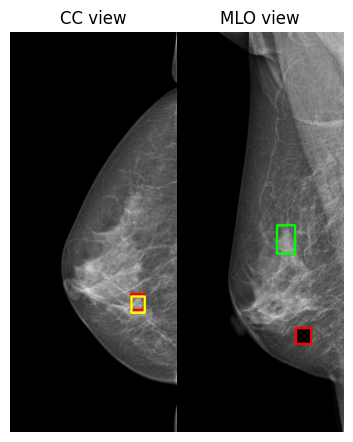

  1%|█▋                                                                                                                                                                                               | 17/2000 [00:41<1:15:34,  2.29s/it]

True


  1%|█▋                                                                                                                                                                                               | 18/2000 [00:43<1:14:07,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▊                                                                                                                                                                                               | 19/2000 [00:45<1:13:19,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|█▉                                                                                                                                                                                               | 20/2000 [00:48<1:12:14,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██                                                                                                                                                                                               | 21/2000 [00:50<1:12:23,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██                                                                                                                                                                                               | 22/2000 [00:52<1:12:25,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▏                                                                                                                                                                                              | 23/2000 [00:54<1:13:58,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▎                                                                                                                                                                                              | 24/2000 [00:57<1:14:32,  2.26s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▍                                                                                                                                                                                              | 25/2000 [00:59<1:13:19,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▌                                                                                                                                                                                              | 26/2000 [01:01<1:12:12,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▌                                                                                                                                                                                              | 27/2000 [01:03<1:12:50,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  1%|██▋                                                                                                                                                                                              | 28/2000 [01:05<1:11:45,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0003], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[200.2479, 488.1727, 250.2901, 544.0684]])


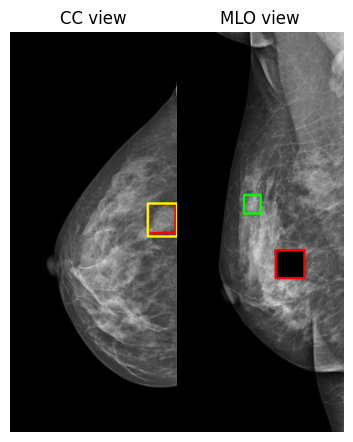

  1%|██▊                                                                                                                                                                                              | 29/2000 [01:08<1:14:23,  2.26s/it]

True


  2%|██▉                                                                                                                                                                                              | 30/2000 [01:10<1:12:42,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0008], grad_fn=<TopkBackward0>)
tensor([16])
tensor([[334.6920, 877.0576, 388.8413, 967.3918]])


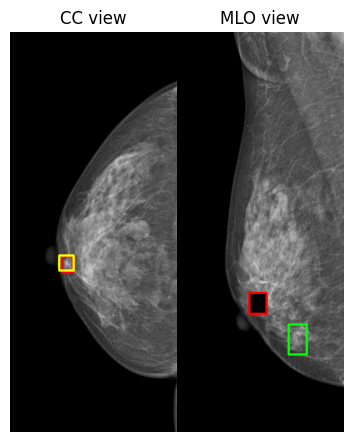

  2%|██▉                                                                                                                                                                                              | 31/2000 [01:12<1:14:59,  2.29s/it]

True


  2%|███                                                                                                                                                                                              | 32/2000 [01:14<1:12:50,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▏                                                                                                                                                                                             | 33/2000 [01:17<1:12:13,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▎                                                                                                                                                                                             | 34/2000 [01:19<1:11:14,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▍                                                                                                                                                                                             | 35/2000 [01:21<1:11:40,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▍                                                                                                                                                                                             | 36/2000 [01:23<1:11:23,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▌                                                                                                                                                                                             | 37/2000 [01:25<1:11:26,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▋                                                                                                                                                                                             | 38/2000 [01:27<1:11:05,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▊                                                                                                                                                                                             | 39/2000 [01:30<1:10:53,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▊                                                                                                                                                                                             | 40/2000 [01:32<1:10:29,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|███▉                                                                                                                                                                                             | 41/2000 [01:34<1:10:44,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████                                                                                                                                                                                             | 42/2000 [01:36<1:10:52,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▏                                                                                                                                                                                            | 43/2000 [01:38<1:12:02,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▏                                                                                                                                                                                            | 44/2000 [01:40<1:11:01,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▎                                                                                                                                                                                            | 45/2000 [01:43<1:10:38,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▍                                                                                                                                                                                            | 46/2000 [01:45<1:10:09,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▌                                                                                                                                                                                            | 47/2000 [01:47<1:10:41,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▋                                                                                                                                                                                            | 48/2000 [01:49<1:10:27,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  2%|████▋                                                                                                                                                                                            | 49/2000 [01:51<1:10:30,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([6.8774e-05], grad_fn=<TopkBackward0>)
tensor([8])
tensor([[341.3879, 788.4616, 471.9277, 922.3692]])


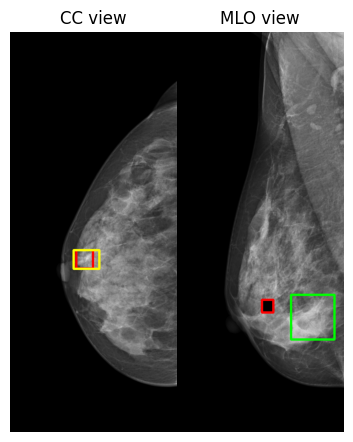

  2%|████▊                                                                                                                                                                                            | 50/2000 [01:54<1:12:47,  2.24s/it]

True


  3%|████▉                                                                                                                                                                                            | 51/2000 [01:56<1:11:51,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████                                                                                                                                                                                            | 52/2000 [01:58<1:11:49,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████                                                                                                                                                                                            | 53/2000 [02:00<1:11:23,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▏                                                                                                                                                                                           | 54/2000 [02:02<1:11:44,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▎                                                                                                                                                                                           | 55/2000 [02:05<1:11:51,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▍                                                                                                                                                                                           | 56/2000 [02:07<1:11:59,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▌                                                                                                                                                                                           | 57/2000 [02:09<1:11:20,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▌                                                                                                                                                                                           | 58/2000 [02:11<1:11:31,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▋                                                                                                                                                                                           | 59/2000 [02:13<1:10:45,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▊                                                                                                                                                                                           | 60/2000 [02:16<1:11:21,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▉                                                                                                                                                                                           | 61/2000 [02:18<1:11:42,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|█████▉                                                                                                                                                                                           | 62/2000 [02:20<1:11:24,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|██████                                                                                                                                                                                           | 63/2000 [02:22<1:11:31,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|██████▏                                                                                                                                                                                          | 64/2000 [02:25<1:11:20,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|██████▎                                                                                                                                                                                          | 65/2000 [02:27<1:11:50,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|██████▎                                                                                                                                                                                          | 66/2000 [02:29<1:11:36,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|██████▍                                                                                                                                                                                          | 67/2000 [02:31<1:11:30,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|██████▌                                                                                                                                                                                          | 68/2000 [02:33<1:11:58,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  3%|██████▋                                                                                                                                                                                          | 69/2000 [02:36<1:10:44,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████▊                                                                                                                                                                                          | 70/2000 [02:38<1:10:26,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████▊                                                                                                                                                                                          | 71/2000 [02:40<1:10:01,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|██████▉                                                                                                                                                                                          | 72/2000 [02:42<1:10:17,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████                                                                                                                                                                                          | 73/2000 [02:44<1:10:25,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████▏                                                                                                                                                                                         | 74/2000 [02:47<1:11:18,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████▏                                                                                                                                                                                         | 75/2000 [02:49<1:11:38,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████▎                                                                                                                                                                                         | 76/2000 [02:51<1:11:15,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████▍                                                                                                                                                                                         | 77/2000 [02:53<1:10:31,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████▌                                                                                                                                                                                         | 78/2000 [02:55<1:10:39,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████▌                                                                                                                                                                                         | 79/2000 [02:58<1:10:52,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|███████▋                                                                                                                                                                                         | 80/2000 [03:00<1:10:58,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([3.1073e-05], grad_fn=<TopkBackward0>)
tensor([998])
tensor([[271.4295, 806.9244, 292.3355, 835.2615]])


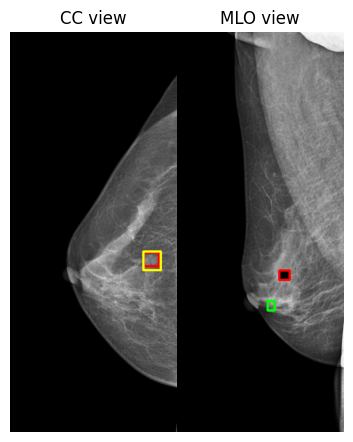

  4%|███████▊                                                                                                                                                                                         | 81/2000 [03:02<1:13:06,  2.29s/it]

True


  4%|███████▉                                                                                                                                                                                         | 82/2000 [03:04<1:11:36,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████                                                                                                                                                                                         | 83/2000 [03:07<1:10:51,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████                                                                                                                                                                                         | 84/2000 [03:09<1:10:06,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████▏                                                                                                                                                                                        | 85/2000 [03:11<1:10:07,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████▎                                                                                                                                                                                        | 86/2000 [03:13<1:09:40,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████▍                                                                                                                                                                                        | 87/2000 [03:15<1:09:35,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████▍                                                                                                                                                                                        | 88/2000 [03:17<1:09:12,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████▌                                                                                                                                                                                        | 89/2000 [03:20<1:09:25,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  4%|████████▋                                                                                                                                                                                        | 90/2000 [03:22<1:08:54,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████▊                                                                                                                                                                                        | 91/2000 [03:24<1:09:18,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████▉                                                                                                                                                                                        | 92/2000 [03:26<1:09:27,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|████████▉                                                                                                                                                                                        | 93/2000 [03:28<1:09:22,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████                                                                                                                                                                                        | 94/2000 [03:31<1:09:09,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▏                                                                                                                                                                                       | 95/2000 [03:33<1:09:09,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▎                                                                                                                                                                                       | 96/2000 [03:35<1:08:51,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▎                                                                                                                                                                                       | 97/2000 [03:37<1:09:11,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▍                                                                                                                                                                                       | 98/2000 [03:39<1:08:20,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▌                                                                                                                                                                                       | 99/2000 [03:41<1:09:13,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▌                                                                                                                                                                                      | 100/2000 [03:44<1:09:23,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▋                                                                                                                                                                                      | 101/2000 [03:46<1:09:37,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▊                                                                                                                                                                                      | 102/2000 [03:48<1:09:07,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▉                                                                                                                                                                                      | 103/2000 [03:50<1:09:29,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|█████████▉                                                                                                                                                                                      | 104/2000 [03:52<1:09:17,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████                                                                                                                                                                                      | 105/2000 [03:55<1:09:33,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████▏                                                                                                                                                                                     | 106/2000 [03:57<1:09:00,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████▎                                                                                                                                                                                     | 107/2000 [03:59<1:09:10,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████▎                                                                                                                                                                                     | 108/2000 [04:01<1:08:45,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  5%|██████████▍                                                                                                                                                                                     | 109/2000 [04:03<1:09:20,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|██████████▌                                                                                                                                                                                     | 110/2000 [04:06<1:08:52,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|██████████▋                                                                                                                                                                                     | 111/2000 [04:08<1:09:02,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|██████████▊                                                                                                                                                                                     | 112/2000 [04:10<1:09:20,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|██████████▊                                                                                                                                                                                     | 113/2000 [04:12<1:10:12,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|██████████▉                                                                                                                                                                                     | 114/2000 [04:14<1:09:51,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████                                                                                                                                                                                     | 115/2000 [04:17<1:09:05,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▏                                                                                                                                                                                    | 116/2000 [04:19<1:08:44,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▏                                                                                                                                                                                    | 117/2000 [04:21<1:08:01,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▎                                                                                                                                                                                    | 118/2000 [04:23<1:08:29,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▍                                                                                                                                                                                    | 119/2000 [04:25<1:08:46,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▌                                                                                                                                                                                    | 120/2000 [04:28<1:08:40,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▌                                                                                                                                                                                    | 121/2000 [04:30<1:08:54,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▋                                                                                                                                                                                    | 122/2000 [04:32<1:09:06,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▊                                                                                                                                                                                    | 123/2000 [04:34<1:09:06,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|███████████▉                                                                                                                                                                                    | 124/2000 [04:36<1:08:58,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████                                                                                                                                                                                    | 125/2000 [04:39<1:08:58,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████                                                                                                                                                                                    | 126/2000 [04:41<1:09:23,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  6%|████████████▏                                                                                                                                                                                   | 127/2000 [04:43<1:08:48,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([7.9674e-05], grad_fn=<TopkBackward0>)
tensor([705])
tensor([[450.4798, 169.7826, 474.4868, 218.2439]])


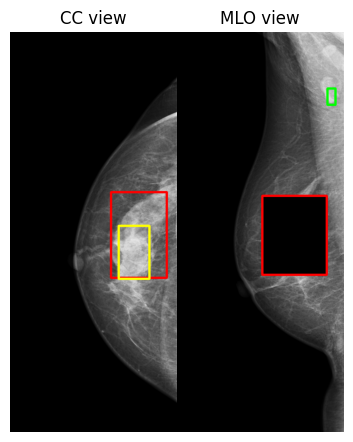

  6%|████████████▎                                                                                                                                                                                   | 128/2000 [04:45<1:11:12,  2.28s/it]

True


  6%|████████████▍                                                                                                                                                                                   | 129/2000 [04:48<1:10:04,  2.25s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0002], grad_fn=<TopkBackward0>)
tensor([6])
tensor([[307.9976, 830.6689, 351.8634, 875.4026]])


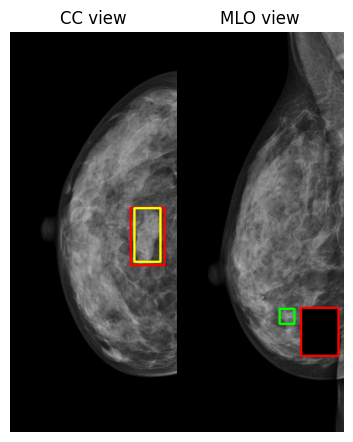

  6%|████████████▍                                                                                                                                                                                   | 130/2000 [04:50<1:12:19,  2.32s/it]

True


  7%|████████████▌                                                                                                                                                                                   | 131/2000 [04:52<1:09:49,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|████████████▋                                                                                                                                                                                   | 132/2000 [04:54<1:08:58,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|████████████▊                                                                                                                                                                                   | 133/2000 [04:56<1:07:42,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|████████████▊                                                                                                                                                                                   | 134/2000 [04:59<1:08:01,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|████████████▉                                                                                                                                                                                   | 135/2000 [05:01<1:07:37,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████                                                                                                                                                                                   | 136/2000 [05:03<1:07:44,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([2.3011e-05], grad_fn=<TopkBackward0>)
tensor([236])
tensor([[294.3746, 665.9791, 312.3441, 681.9517]])


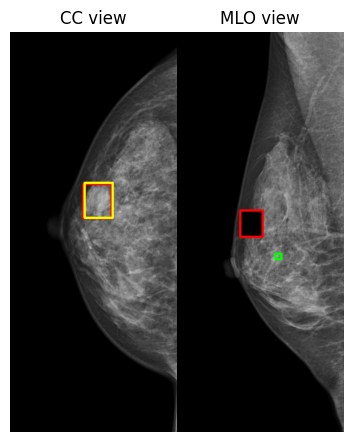

  7%|█████████████▏                                                                                                                                                                                  | 137/2000 [05:05<1:09:32,  2.24s/it]

True


  7%|█████████████▏                                                                                                                                                                                  | 138/2000 [05:08<1:08:56,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████▎                                                                                                                                                                                  | 139/2000 [05:10<1:09:59,  2.26s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████▍                                                                                                                                                                                  | 140/2000 [05:12<1:09:24,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████▌                                                                                                                                                                                  | 141/2000 [05:14<1:08:50,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████▋                                                                                                                                                                                  | 142/2000 [05:16<1:08:15,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████▋                                                                                                                                                                                  | 143/2000 [05:19<1:08:03,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|█████████████▊                                                                                                                                                                                  | 144/2000 [05:21<1:08:22,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0001], grad_fn=<TopkBackward0>)
tensor([17])
tensor([[199.0466, 531.6022, 226.7176, 564.9990]])


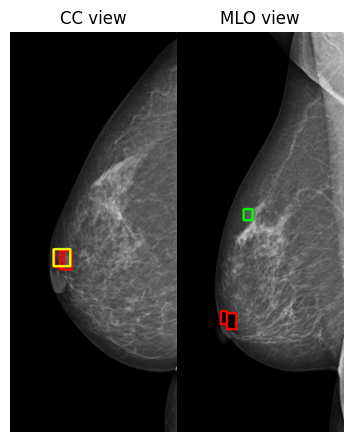

torch.Size([8, 1000, 1000])
tensor([0.0001], grad_fn=<TopkBackward0>)
tensor([17])
tensor([[199.0466, 531.6022, 226.7176, 564.9990]])


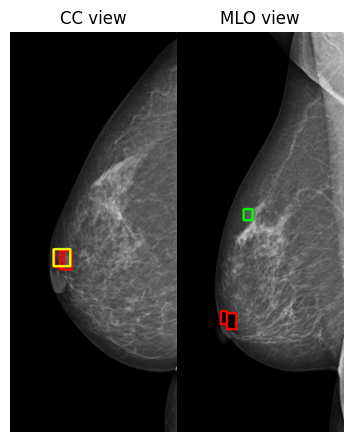

  7%|█████████████▉                                                                                                                                                                                  | 145/2000 [05:24<1:12:47,  2.35s/it]

True


  7%|██████████████                                                                                                                                                                                  | 146/2000 [05:26<1:09:58,  2.26s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████                                                                                                                                                                                  | 147/2000 [05:28<1:08:50,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████▏                                                                                                                                                                                 | 148/2000 [05:30<1:07:34,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  7%|██████████████▎                                                                                                                                                                                 | 149/2000 [05:32<1:07:19,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████▍                                                                                                                                                                                 | 150/2000 [05:34<1:06:42,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████▍                                                                                                                                                                                 | 151/2000 [05:36<1:07:43,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████▌                                                                                                                                                                                 | 152/2000 [05:39<1:07:30,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████▋                                                                                                                                                                                 | 153/2000 [05:41<1:07:15,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████▊                                                                                                                                                                                 | 154/2000 [05:43<1:07:30,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████▉                                                                                                                                                                                 | 155/2000 [05:45<1:07:13,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|██████████████▉                                                                                                                                                                                 | 156/2000 [05:47<1:07:33,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████                                                                                                                                                                                 | 157/2000 [05:50<1:06:59,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▏                                                                                                                                                                                | 158/2000 [05:52<1:06:35,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▎                                                                                                                                                                                | 159/2000 [05:54<1:07:10,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▎                                                                                                                                                                                | 160/2000 [05:56<1:08:24,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▍                                                                                                                                                                                | 161/2000 [05:58<1:08:00,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▌                                                                                                                                                                                | 162/2000 [06:01<1:07:55,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▋                                                                                                                                                                                | 163/2000 [06:03<1:07:51,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▋                                                                                                                                                                                | 164/2000 [06:05<1:07:01,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▊                                                                                                                                                                                | 165/2000 [06:07<1:06:47,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|███████████████▉                                                                                                                                                                                | 166/2000 [06:09<1:06:24,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████                                                                                                                                                                                | 167/2000 [06:11<1:06:43,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████▏                                                                                                                                                                               | 168/2000 [06:14<1:06:06,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████▏                                                                                                                                                                               | 169/2000 [06:16<1:06:18,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  8%|████████████████▎                                                                                                                                                                               | 170/2000 [06:18<1:06:16,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([8])
tensor([[196.2732, 605.3017, 246.4279, 675.9161]])


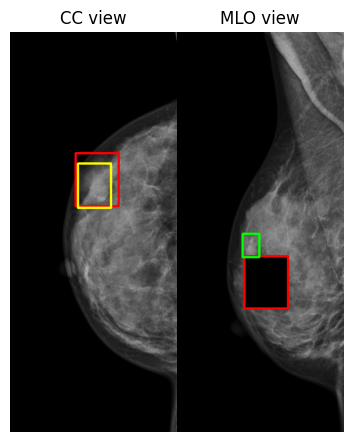

  9%|████████████████▍                                                                                                                                                                               | 171/2000 [06:20<1:09:20,  2.27s/it]

True


  9%|████████████████▌                                                                                                                                                                               | 172/2000 [06:23<1:08:12,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████▌                                                                                                                                                                               | 173/2000 [06:25<1:08:12,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████▋                                                                                                                                                                               | 174/2000 [06:27<1:07:33,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([3])
tensor([[303.2971, 754.9089, 342.4172, 795.0787]])


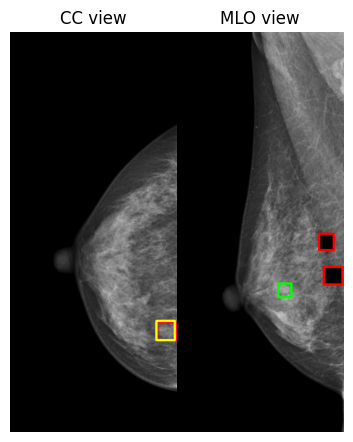

  9%|████████████████▊                                                                                                                                                                               | 175/2000 [06:30<1:09:52,  2.30s/it]

True


  9%|████████████████▉                                                                                                                                                                               | 176/2000 [06:32<1:07:41,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|████████████████▉                                                                                                                                                                               | 177/2000 [06:34<1:06:47,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████                                                                                                                                                                               | 178/2000 [06:36<1:06:10,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████▏                                                                                                                                                                              | 179/2000 [06:38<1:06:50,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████▎                                                                                                                                                                              | 180/2000 [06:40<1:05:49,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████▍                                                                                                                                                                              | 181/2000 [06:42<1:05:34,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████▍                                                                                                                                                                              | 182/2000 [06:44<1:04:42,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([15])
tensor([[270.5310, 816.4061, 364.9856, 872.8245]])


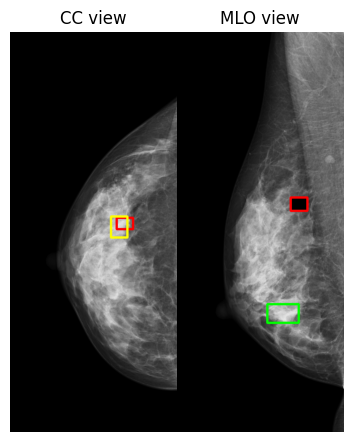

  9%|█████████████████▌                                                                                                                                                                              | 183/2000 [06:47<1:07:37,  2.23s/it]

True


  9%|█████████████████▋                                                                                                                                                                              | 184/2000 [06:49<1:06:35,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████▊                                                                                                                                                                              | 185/2000 [06:51<1:06:23,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████▊                                                                                                                                                                              | 186/2000 [06:53<1:05:26,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|█████████████████▉                                                                                                                                                                              | 187/2000 [06:55<1:05:45,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|██████████████████                                                                                                                                                                              | 188/2000 [06:58<1:05:15,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


  9%|██████████████████▏                                                                                                                                                                             | 189/2000 [07:00<1:05:31,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████▏                                                                                                                                                                             | 190/2000 [07:02<1:05:10,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0007], grad_fn=<TopkBackward0>)
tensor([3])
tensor([[370.2867, 344.4669, 430.8383, 402.1591]])


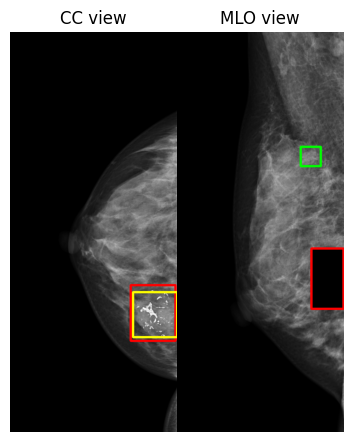

 10%|██████████████████▎                                                                                                                                                                             | 191/2000 [07:04<1:07:48,  2.25s/it]

True


 10%|██████████████████▍                                                                                                                                                                             | 192/2000 [07:07<1:06:43,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████▌                                                                                                                                                                             | 193/2000 [07:09<1:06:31,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████▌                                                                                                                                                                             | 194/2000 [07:11<1:05:48,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████▋                                                                                                                                                                             | 195/2000 [07:13<1:05:57,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████▊                                                                                                                                                                             | 196/2000 [07:15<1:05:24,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|██████████████████▉                                                                                                                                                                             | 197/2000 [07:17<1:05:19,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████                                                                                                                                                                             | 198/2000 [07:19<1:04:28,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████                                                                                                                                                                             | 199/2000 [07:22<1:04:36,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████▏                                                                                                                                                                            | 200/2000 [07:24<1:04:07,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████▎                                                                                                                                                                            | 201/2000 [07:26<1:04:02,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████▍                                                                                                                                                                            | 202/2000 [07:28<1:04:06,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████▍                                                                                                                                                                            | 203/2000 [07:30<1:04:33,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([14])
tensor([[386.0862, 754.3753, 432.0078, 809.6208]])


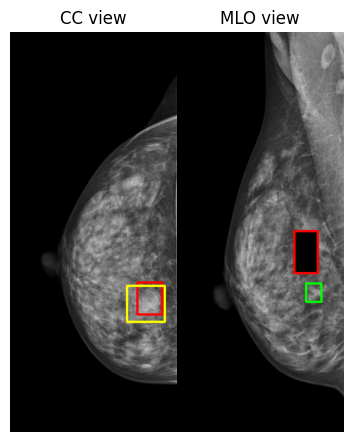

 10%|███████████████████▌                                                                                                                                                                            | 204/2000 [07:33<1:07:18,  2.25s/it]

True


 10%|███████████████████▋                                                                                                                                                                            | 205/2000 [07:35<1:05:58,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0003], grad_fn=<TopkBackward0>)
tensor([1])
tensor([[229.9314, 445.7181, 371.2241, 628.8418]])


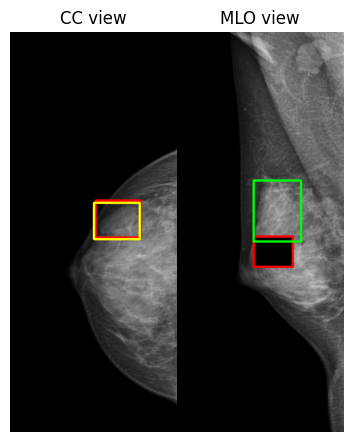

 10%|███████████████████▊                                                                                                                                                                            | 206/2000 [07:37<1:09:57,  2.34s/it]

True


 10%|███████████████████▊                                                                                                                                                                            | 207/2000 [07:40<1:07:51,  2.27s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|███████████████████▉                                                                                                                                                                            | 208/2000 [07:42<1:06:19,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|████████████████████                                                                                                                                                                            | 209/2000 [07:44<1:05:09,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 10%|████████████████████▏                                                                                                                                                                           | 210/2000 [07:46<1:05:09,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▎                                                                                                                                                                           | 211/2000 [07:48<1:04:09,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▎                                                                                                                                                                           | 212/2000 [07:50<1:04:02,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▍                                                                                                                                                                           | 213/2000 [07:52<1:03:53,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▌                                                                                                                                                                           | 214/2000 [07:54<1:04:02,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▋                                                                                                                                                                           | 215/2000 [07:56<1:03:04,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▋                                                                                                                                                                           | 216/2000 [07:59<1:03:39,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▊                                                                                                                                                                           | 217/2000 [08:01<1:02:54,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|████████████████████▉                                                                                                                                                                           | 218/2000 [08:03<1:02:36,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████                                                                                                                                                                           | 219/2000 [08:05<1:02:38,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████                                                                                                                                                                           | 220/2000 [08:07<1:02:42,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▏                                                                                                                                                                          | 221/2000 [08:09<1:02:10,  2.10s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▎                                                                                                                                                                          | 222/2000 [08:11<1:02:39,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▍                                                                                                                                                                          | 223/2000 [08:13<1:02:49,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▌                                                                                                                                                                          | 224/2000 [08:16<1:02:50,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▌                                                                                                                                                                          | 225/2000 [08:18<1:03:15,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▋                                                                                                                                                                          | 226/2000 [08:20<1:04:07,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▊                                                                                                                                                                          | 227/2000 [08:22<1:02:50,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▉                                                                                                                                                                          | 228/2000 [08:24<1:01:55,  2.10s/it]

torch.Size([1000])
torch.Size([1000])
True


 11%|█████████████████████▉                                                                                                                                                                          | 229/2000 [08:26<1:01:31,  2.08s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([5.0473e-05], grad_fn=<TopkBackward0>)
tensor([726])
tensor([[188.2854, 606.3903, 215.8998, 645.7520]])


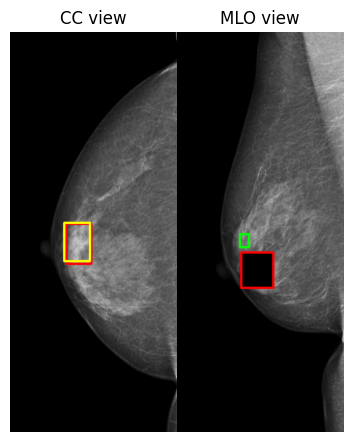

 12%|██████████████████████                                                                                                                                                                          | 230/2000 [08:28<1:04:09,  2.17s/it]

True


 12%|██████████████████████▏                                                                                                                                                                         | 231/2000 [08:31<1:03:11,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|██████████████████████▎                                                                                                                                                                         | 232/2000 [08:33<1:03:40,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|██████████████████████▎                                                                                                                                                                         | 233/2000 [08:35<1:03:26,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|██████████████████████▍                                                                                                                                                                         | 234/2000 [08:37<1:03:22,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([6.7291e-05], grad_fn=<TopkBackward0>)
tensor([777])
tensor([[354.0123, 336.2295, 371.5438, 351.9411]])


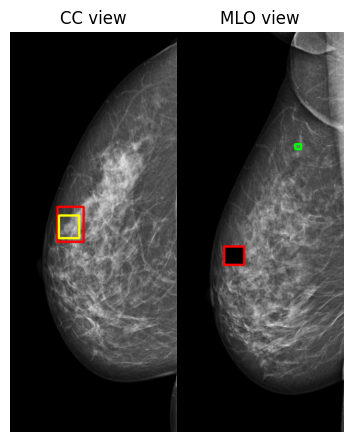

 12%|██████████████████████▌                                                                                                                                                                         | 235/2000 [08:39<1:05:09,  2.21s/it]

True


 12%|██████████████████████▋                                                                                                                                                                         | 236/2000 [08:41<1:04:04,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|██████████████████████▊                                                                                                                                                                         | 237/2000 [08:44<1:04:02,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|██████████████████████▊                                                                                                                                                                         | 238/2000 [08:46<1:03:33,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|██████████████████████▉                                                                                                                                                                         | 239/2000 [08:48<1:03:27,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████                                                                                                                                                                         | 240/2000 [08:50<1:02:37,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▏                                                                                                                                                                        | 241/2000 [08:52<1:02:47,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▏                                                                                                                                                                        | 242/2000 [08:54<1:02:46,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▎                                                                                                                                                                        | 243/2000 [08:56<1:02:52,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▍                                                                                                                                                                        | 244/2000 [08:59<1:03:08,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▌                                                                                                                                                                        | 245/2000 [09:01<1:03:12,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▌                                                                                                                                                                        | 246/2000 [09:03<1:02:48,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▋                                                                                                                                                                        | 247/2000 [09:05<1:02:08,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 12%|███████████████████████▊                                                                                                                                                                        | 248/2000 [09:07<1:02:19,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0005], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[241.5805, 626.8394, 303.0804, 683.0158]])


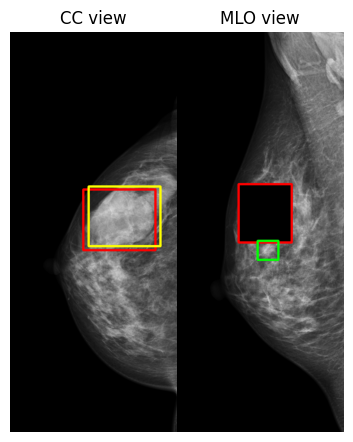

 12%|███████████████████████▉                                                                                                                                                                        | 249/2000 [09:10<1:04:33,  2.21s/it]

True


 12%|████████████████████████                                                                                                                                                                        | 250/2000 [09:12<1:03:59,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████                                                                                                                                                                        | 251/2000 [09:14<1:03:15,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▏                                                                                                                                                                       | 252/2000 [09:16<1:02:33,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▎                                                                                                                                                                       | 253/2000 [09:18<1:02:11,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▍                                                                                                                                                                       | 254/2000 [09:20<1:01:45,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▍                                                                                                                                                                       | 255/2000 [09:22<1:02:16,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▌                                                                                                                                                                       | 256/2000 [09:24<1:01:46,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▋                                                                                                                                                                       | 257/2000 [09:26<1:01:33,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▊                                                                                                                                                                       | 258/2000 [09:29<1:01:23,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▊                                                                                                                                                                       | 259/2000 [09:31<1:02:05,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|████████████████████████▉                                                                                                                                                                       | 260/2000 [09:33<1:02:26,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████                                                                                                                                                                       | 261/2000 [09:35<1:02:16,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▏                                                                                                                                                                      | 262/2000 [09:37<1:01:52,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▏                                                                                                                                                                      | 263/2000 [09:39<1:02:20,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▎                                                                                                                                                                      | 264/2000 [09:42<1:02:26,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▍                                                                                                                                                                      | 265/2000 [09:44<1:02:12,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▌                                                                                                                                                                      | 266/2000 [09:46<1:02:02,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▋                                                                                                                                                                      | 267/2000 [09:48<1:02:56,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▋                                                                                                                                                                      | 268/2000 [09:50<1:03:08,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 13%|█████████████████████████▊                                                                                                                                                                      | 269/2000 [09:53<1:03:31,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|█████████████████████████▉                                                                                                                                                                      | 270/2000 [09:55<1:02:53,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████                                                                                                                                                                      | 271/2000 [09:57<1:02:46,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████                                                                                                                                                                      | 272/2000 [09:59<1:03:10,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▏                                                                                                                                                                     | 273/2000 [10:01<1:03:27,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▎                                                                                                                                                                     | 274/2000 [10:03<1:02:50,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▍                                                                                                                                                                     | 275/2000 [10:06<1:02:22,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▍                                                                                                                                                                     | 276/2000 [10:08<1:01:55,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▌                                                                                                                                                                     | 277/2000 [10:10<1:02:24,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▋                                                                                                                                                                     | 278/2000 [10:12<1:01:39,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▊                                                                                                                                                                     | 279/2000 [10:14<1:01:34,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▉                                                                                                                                                                     | 280/2000 [10:16<1:01:33,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|██████████████████████████▉                                                                                                                                                                     | 281/2000 [10:18<1:01:33,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████                                                                                                                                                                     | 282/2000 [10:21<1:01:15,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▏                                                                                                                                                                    | 283/2000 [10:23<1:01:17,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▎                                                                                                                                                                    | 284/2000 [10:25<1:01:12,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▎                                                                                                                                                                    | 285/2000 [10:27<1:01:25,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▍                                                                                                                                                                    | 286/2000 [10:29<1:01:26,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▌                                                                                                                                                                    | 287/2000 [10:31<1:01:21,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▋                                                                                                                                                                    | 288/2000 [10:34<1:01:35,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▋                                                                                                                                                                    | 289/2000 [10:36<1:01:13,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 14%|███████████████████████████▊                                                                                                                                                                    | 290/2000 [10:38<1:00:54,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|███████████████████████████▉                                                                                                                                                                    | 291/2000 [10:40<1:01:06,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████                                                                                                                                                                    | 292/2000 [10:42<1:00:51,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▏                                                                                                                                                                   | 293/2000 [10:44<1:00:47,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▏                                                                                                                                                                   | 294/2000 [10:46<1:00:46,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▎                                                                                                                                                                   | 295/2000 [10:48<1:00:42,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▍                                                                                                                                                                   | 296/2000 [10:51<1:00:51,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▌                                                                                                                                                                   | 297/2000 [10:53<1:01:03,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▌                                                                                                                                                                   | 298/2000 [10:55<1:01:51,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▋                                                                                                                                                                   | 299/2000 [10:57<1:02:04,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▊                                                                                                                                                                   | 300/2000 [10:59<1:01:25,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▉                                                                                                                                                                   | 301/2000 [11:02<1:01:50,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|████████████████████████████▉                                                                                                                                                                   | 302/2000 [11:04<1:01:08,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████                                                                                                                                                                   | 303/2000 [11:06<1:00:42,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████▏                                                                                                                                                                  | 304/2000 [11:08<1:01:06,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████▎                                                                                                                                                                  | 305/2000 [11:10<1:00:48,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████▍                                                                                                                                                                  | 306/2000 [11:12<1:00:49,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████▍                                                                                                                                                                  | 307/2000 [11:14<1:00:53,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████▌                                                                                                                                                                  | 308/2000 [11:17<1:00:24,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 15%|█████████████████████████████▋                                                                                                                                                                  | 309/2000 [11:19<1:00:40,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|█████████████████████████████▊                                                                                                                                                                  | 310/2000 [11:21<1:00:33,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|█████████████████████████████▊                                                                                                                                                                  | 311/2000 [11:23<1:00:46,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|█████████████████████████████▉                                                                                                                                                                  | 312/2000 [11:25<1:00:30,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▎                                                                                                                                                                   | 313/2000 [11:27<59:45,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▍                                                                                                                                                                   | 314/2000 [11:29<59:27,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▌                                                                                                                                                                   | 315/2000 [11:31<59:37,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▋                                                                                                                                                                   | 316/2000 [11:34<59:13,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▍                                                                                                                                                                 | 317/2000 [11:36<1:00:25,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▌                                                                                                                                                                 | 318/2000 [11:38<1:00:28,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▌                                                                                                                                                                 | 319/2000 [11:40<1:00:29,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▋                                                                                                                                                                 | 320/2000 [11:42<1:00:23,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▊                                                                                                                                                                 | 321/2000 [11:44<1:00:09,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|██████████████████████████████▉                                                                                                                                                                 | 322/2000 [11:47<1:00:16,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████                                                                                                                                                                 | 323/2000 [11:49<1:00:14,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0003], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[340.3133, 699.7169, 491.8581, 850.0264]])


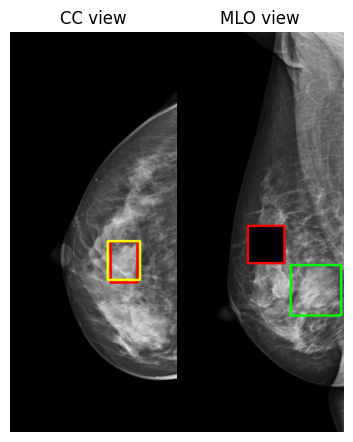

 16%|███████████████████████████████                                                                                                                                                                 | 324/2000 [11:51<1:02:30,  2.24s/it]

True


 16%|███████████████████████████████▏                                                                                                                                                                | 325/2000 [11:53<1:01:33,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0002], grad_fn=<TopkBackward0>)
tensor([6])
tensor([[332.3953, 929.1074, 384.1752, 976.7813]])


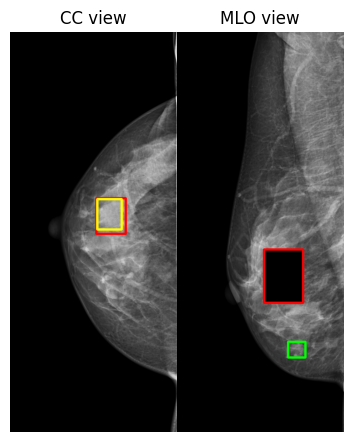

 16%|███████████████████████████████▎                                                                                                                                                                | 326/2000 [11:56<1:02:53,  2.25s/it]

True


 16%|███████████████████████████████▍                                                                                                                                                                | 327/2000 [11:58<1:01:23,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████▍                                                                                                                                                                | 328/2000 [12:00<1:01:19,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████▌                                                                                                                                                                | 329/2000 [12:02<1:00:45,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 16%|███████████████████████████████▋                                                                                                                                                                | 330/2000 [12:04<1:00:58,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|███████████████████████████████▊                                                                                                                                                                | 331/2000 [12:06<1:00:14,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|███████████████████████████████▊                                                                                                                                                                | 332/2000 [12:09<1:00:27,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▎                                                                                                                                                                 | 333/2000 [12:11<59:32,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▍                                                                                                                                                                 | 334/2000 [12:13<59:30,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▍                                                                                                                                                                 | 335/2000 [12:15<59:01,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▌                                                                                                                                                                 | 336/2000 [12:17<59:28,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▋                                                                                                                                                                 | 337/2000 [12:19<59:32,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▊                                                                                                                                                                 | 338/2000 [12:21<59:30,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▉                                                                                                                                                                 | 339/2000 [12:24<59:32,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|████████████████████████████████▉                                                                                                                                                                 | 340/2000 [12:26<59:41,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████                                                                                                                                                                 | 341/2000 [12:28<59:24,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████▏                                                                                                                                                                | 342/2000 [12:30<59:27,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████▎                                                                                                                                                                | 343/2000 [12:32<58:42,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████▎                                                                                                                                                                | 344/2000 [12:34<58:43,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0002], grad_fn=<TopkBackward0>)
tensor([236])
tensor([[180.9702, 597.9026, 260.7096, 654.8782]])


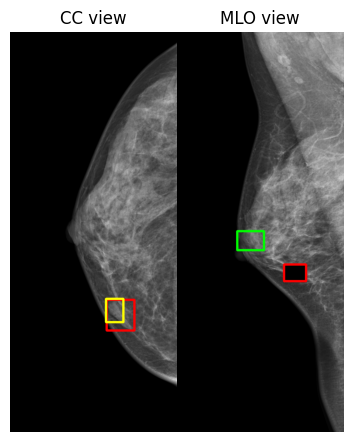

torch.Size([8, 1000, 1000])
tensor([1.7592e-05], grad_fn=<TopkBackward0>)
tensor([236])
tensor([[180.9702, 597.9026, 260.7096, 654.8782]])


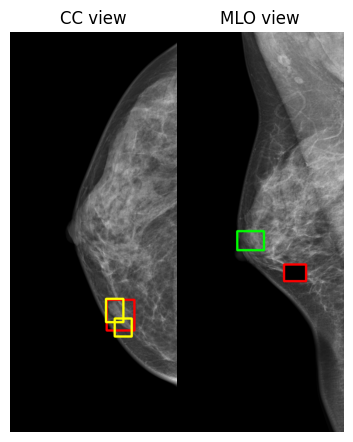

 17%|█████████████████████████████████                                                                                                                                                               | 345/2000 [12:37<1:02:42,  2.27s/it]

True


 17%|█████████████████████████████████▏                                                                                                                                                              | 346/2000 [12:39<1:01:59,  2.25s/it]

torch.Size([1000])
torch.Size([1000])
True


 17%|█████████████████████████████████▎                                                                                                                                                              | 347/2000 [12:41<1:01:01,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0003], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[180.4098, 831.0392, 239.1366, 898.7047]])


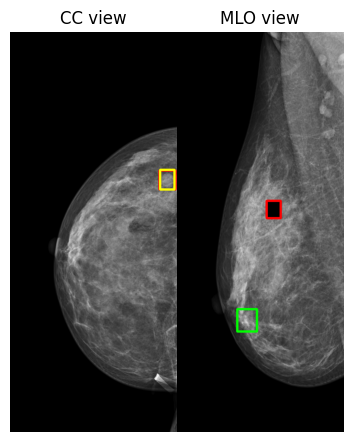

 17%|█████████████████████████████████▍                                                                                                                                                              | 348/2000 [12:44<1:02:48,  2.28s/it]

True


 17%|█████████████████████████████████▌                                                                                                                                                              | 349/2000 [12:46<1:01:43,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████▌                                                                                                                                                              | 350/2000 [12:48<1:00:51,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████▋                                                                                                                                                              | 351/2000 [12:50<1:00:02,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|█████████████████████████████████▊                                                                                                                                                              | 352/2000 [12:52<1:00:08,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▏                                                                                                                                                               | 353/2000 [12:54<59:17,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▎                                                                                                                                                               | 354/2000 [12:57<59:47,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▍                                                                                                                                                               | 355/2000 [12:59<59:17,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▌                                                                                                                                                               | 356/2000 [13:01<58:55,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▋                                                                                                                                                               | 357/2000 [13:03<58:41,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▋                                                                                                                                                               | 358/2000 [13:05<58:23,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▊                                                                                                                                                               | 359/2000 [13:07<58:11,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|██████████████████████████████████▉                                                                                                                                                               | 360/2000 [13:09<59:16,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████                                                                                                                                                               | 361/2000 [13:12<59:01,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████                                                                                                                                                               | 362/2000 [13:14<58:55,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████▏                                                                                                                                                              | 363/2000 [13:16<58:39,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████▎                                                                                                                                                              | 364/2000 [13:18<58:48,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0004], grad_fn=<TopkBackward0>)
tensor([1])
tensor([[422.2245, 653.6103, 474.3885, 706.3985]])


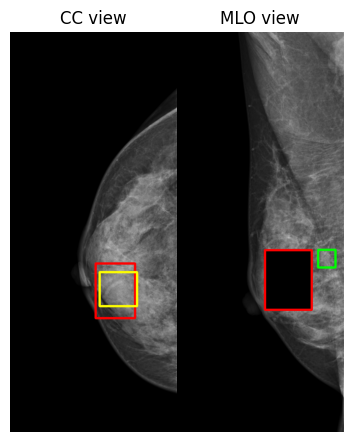

torch.Size([8, 1000, 1000])
tensor([6.8888e-06], grad_fn=<TopkBackward0>)
tensor([847])
tensor([[431.0203, 665.1797, 444.3232, 681.9347]])


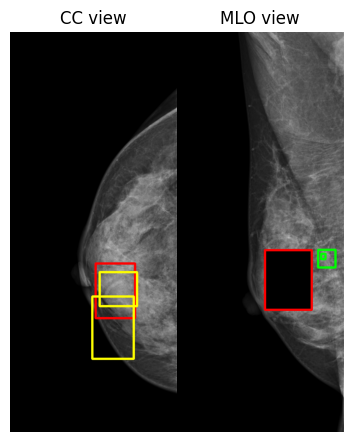

 18%|███████████████████████████████████                                                                                                                                                             | 365/2000 [13:21<1:02:50,  2.31s/it]

True


 18%|███████████████████████████████████▏                                                                                                                                                            | 366/2000 [13:23<1:01:32,  2.26s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████▏                                                                                                                                                            | 367/2000 [13:25<1:00:40,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████▎                                                                                                                                                            | 368/2000 [13:27<1:00:19,  2.22s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████▊                                                                                                                                                              | 369/2000 [13:29<59:35,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 18%|███████████████████████████████████▉                                                                                                                                                              | 370/2000 [13:31<58:58,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|███████████████████████████████████▉                                                                                                                                                              | 371/2000 [13:34<59:18,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████                                                                                                                                                              | 372/2000 [13:36<59:13,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▏                                                                                                                                                             | 373/2000 [13:38<58:33,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▎                                                                                                                                                             | 374/2000 [13:40<58:03,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▍                                                                                                                                                             | 375/2000 [13:42<58:17,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▍                                                                                                                                                             | 376/2000 [13:44<58:37,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▌                                                                                                                                                             | 377/2000 [13:47<58:37,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▋                                                                                                                                                             | 378/2000 [13:49<58:18,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▊                                                                                                                                                             | 379/2000 [13:51<58:24,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▊                                                                                                                                                             | 380/2000 [13:53<58:18,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|████████████████████████████████████▉                                                                                                                                                             | 381/2000 [13:55<58:07,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████                                                                                                                                                             | 382/2000 [13:57<58:13,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████▏                                                                                                                                                            | 383/2000 [13:59<57:52,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████▏                                                                                                                                                            | 384/2000 [14:02<58:11,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████▎                                                                                                                                                            | 385/2000 [14:04<58:28,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████▍                                                                                                                                                            | 386/2000 [14:06<58:35,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████▌                                                                                                                                                            | 387/2000 [14:08<58:09,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████▋                                                                                                                                                            | 388/2000 [14:10<57:58,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 19%|█████████████████████████████████████▋                                                                                                                                                            | 389/2000 [14:12<58:18,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|█████████████████████████████████████▊                                                                                                                                                            | 390/2000 [14:15<58:15,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|█████████████████████████████████████▉                                                                                                                                                            | 391/2000 [14:17<57:57,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████                                                                                                                                                            | 392/2000 [14:19<57:40,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████                                                                                                                                                            | 393/2000 [14:21<57:28,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▏                                                                                                                                                           | 394/2000 [14:23<57:12,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▎                                                                                                                                                           | 395/2000 [14:25<57:42,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▍                                                                                                                                                           | 396/2000 [14:28<58:19,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▌                                                                                                                                                           | 397/2000 [14:30<58:42,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▌                                                                                                                                                           | 398/2000 [14:32<58:31,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▋                                                                                                                                                           | 399/2000 [14:34<58:13,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▊                                                                                                                                                           | 400/2000 [14:36<58:23,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|██████████████████████████████████████▉                                                                                                                                                           | 401/2000 [14:39<58:02,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([8.6693e-05], grad_fn=<TopkBackward0>)
tensor([629])
tensor([[377.7372, 298.5938, 500.0000, 505.8095]])


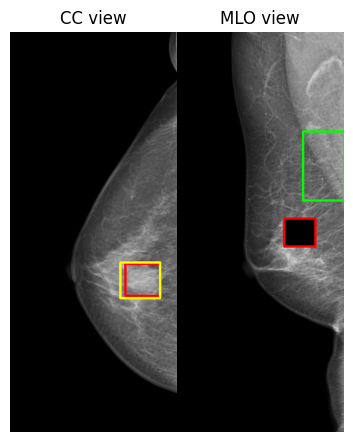

 20%|██████████████████████████████████████▌                                                                                                                                                         | 402/2000 [14:41<1:00:29,  2.27s/it]

True


 20%|███████████████████████████████████████                                                                                                                                                           | 403/2000 [14:43<58:56,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████▏                                                                                                                                                          | 404/2000 [14:45<58:39,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████▎                                                                                                                                                          | 405/2000 [14:47<57:41,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████▍                                                                                                                                                          | 406/2000 [14:50<57:39,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████▍                                                                                                                                                          | 407/2000 [14:52<57:44,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████▌                                                                                                                                                          | 408/2000 [14:54<57:48,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████▋                                                                                                                                                          | 409/2000 [14:56<57:06,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 20%|███████████████████████████████████████▊                                                                                                                                                          | 410/2000 [14:58<57:14,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|███████████████████████████████████████▊                                                                                                                                                          | 411/2000 [15:00<57:05,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|███████████████████████████████████████▉                                                                                                                                                          | 412/2000 [15:03<56:57,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████                                                                                                                                                          | 413/2000 [15:05<56:31,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▏                                                                                                                                                         | 414/2000 [15:07<57:08,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▎                                                                                                                                                         | 415/2000 [15:09<56:30,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▎                                                                                                                                                         | 416/2000 [15:11<56:32,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▍                                                                                                                                                         | 417/2000 [15:13<55:54,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▌                                                                                                                                                         | 418/2000 [15:15<56:11,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▋                                                                                                                                                         | 419/2000 [15:17<55:47,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▋                                                                                                                                                         | 420/2000 [15:19<55:32,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▊                                                                                                                                                         | 421/2000 [15:22<55:31,  2.11s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|████████████████████████████████████████▉                                                                                                                                                         | 422/2000 [15:24<55:47,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([5.5616e-05], grad_fn=<TopkBackward0>)
tensor([30])
tensor([[221.8786, 606.6389, 300.2890, 656.2105]])


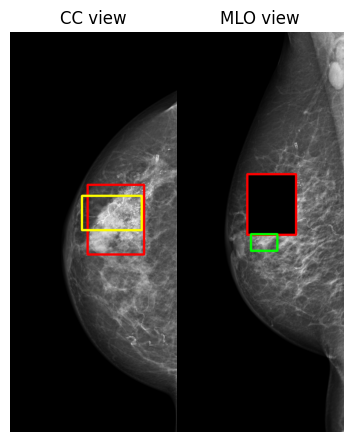

 21%|█████████████████████████████████████████                                                                                                                                                         | 423/2000 [15:26<58:24,  2.22s/it]

True


 21%|█████████████████████████████████████████▏                                                                                                                                                        | 424/2000 [15:28<57:37,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████▏                                                                                                                                                        | 425/2000 [15:31<57:37,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████▎                                                                                                                                                        | 426/2000 [15:33<57:06,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████▍                                                                                                                                                        | 427/2000 [15:35<57:19,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████▌                                                                                                                                                        | 428/2000 [15:37<57:32,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 21%|█████████████████████████████████████████▌                                                                                                                                                        | 429/2000 [15:39<57:25,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|█████████████████████████████████████████▋                                                                                                                                                        | 430/2000 [15:41<56:53,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|█████████████████████████████████████████▊                                                                                                                                                        | 431/2000 [15:44<56:27,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|█████████████████████████████████████████▉                                                                                                                                                        | 432/2000 [15:46<55:57,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████                                                                                                                                                        | 433/2000 [15:48<56:06,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████                                                                                                                                                        | 434/2000 [15:50<56:15,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▏                                                                                                                                                       | 435/2000 [15:52<56:05,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▎                                                                                                                                                       | 436/2000 [15:54<56:49,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▍                                                                                                                                                       | 437/2000 [15:57<57:35,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▍                                                                                                                                                       | 438/2000 [15:59<56:52,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▌                                                                                                                                                       | 439/2000 [16:01<56:37,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▋                                                                                                                                                       | 440/2000 [16:03<56:53,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▊                                                                                                                                                       | 441/2000 [16:05<56:33,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▊                                                                                                                                                       | 442/2000 [16:07<56:15,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|██████████████████████████████████████████▉                                                                                                                                                       | 443/2000 [16:10<56:01,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████                                                                                                                                                       | 444/2000 [16:12<55:56,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████▏                                                                                                                                                      | 445/2000 [16:14<55:31,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████▎                                                                                                                                                      | 446/2000 [16:16<55:37,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████▎                                                                                                                                                      | 447/2000 [16:18<55:25,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0011], grad_fn=<TopkBackward0>)
tensor([107])
tensor([[190.6276, 664.2787, 223.5165, 700.5050]])


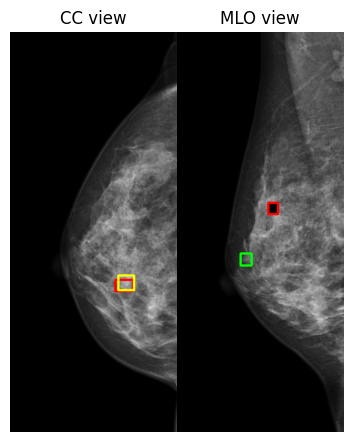

 22%|███████████████████████████████████████████▍                                                                                                                                                      | 448/2000 [16:20<57:22,  2.22s/it]

True


 22%|███████████████████████████████████████████▌                                                                                                                                                      | 449/2000 [16:23<56:02,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 22%|███████████████████████████████████████████▋                                                                                                                                                      | 450/2000 [16:25<56:01,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████▋                                                                                                                                                      | 451/2000 [16:27<55:59,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████▊                                                                                                                                                      | 452/2000 [16:29<56:03,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|███████████████████████████████████████████▉                                                                                                                                                      | 453/2000 [16:31<55:53,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████                                                                                                                                                      | 454/2000 [16:33<56:13,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▏                                                                                                                                                     | 455/2000 [16:36<56:00,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▏                                                                                                                                                     | 456/2000 [16:38<55:37,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▎                                                                                                                                                     | 457/2000 [16:40<55:10,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▍                                                                                                                                                     | 458/2000 [16:42<55:31,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▌                                                                                                                                                     | 459/2000 [16:44<55:13,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▌                                                                                                                                                     | 460/2000 [16:46<55:51,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▋                                                                                                                                                     | 461/2000 [16:48<55:03,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▊                                                                                                                                                     | 462/2000 [16:51<55:17,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|████████████████████████████████████████████▉                                                                                                                                                     | 463/2000 [16:53<54:51,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████                                                                                                                                                     | 464/2000 [16:55<55:08,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████                                                                                                                                                     | 465/2000 [16:57<54:47,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████▏                                                                                                                                                    | 466/2000 [16:59<55:12,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████▎                                                                                                                                                    | 467/2000 [17:01<55:20,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████▍                                                                                                                                                    | 468/2000 [17:04<55:13,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 23%|█████████████████████████████████████████████▍                                                                                                                                                    | 469/2000 [17:06<54:41,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([4.6008e-05], grad_fn=<TopkBackward0>)
tensor([798])
tensor([[  0.0000,   0.0000, 317.3641, 245.0597]])


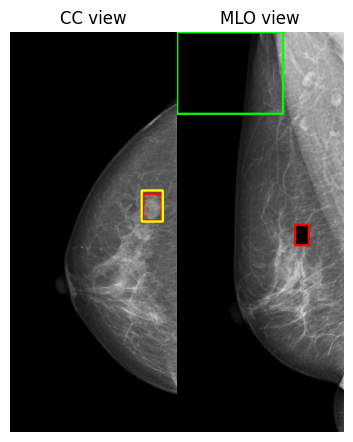

 24%|█████████████████████████████████████████████▌                                                                                                                                                    | 470/2000 [17:08<57:04,  2.24s/it]

True


 24%|█████████████████████████████████████████████▋                                                                                                                                                    | 471/2000 [17:10<56:24,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|█████████████████████████████████████████████▊                                                                                                                                                    | 472/2000 [17:12<55:55,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|█████████████████████████████████████████████▉                                                                                                                                                    | 473/2000 [17:15<55:26,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|█████████████████████████████████████████████▉                                                                                                                                                    | 474/2000 [17:17<55:32,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████                                                                                                                                                    | 475/2000 [17:19<54:44,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████▏                                                                                                                                                   | 476/2000 [17:21<54:48,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████▎                                                                                                                                                   | 477/2000 [17:23<55:09,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████▎                                                                                                                                                   | 478/2000 [17:25<55:42,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0001], grad_fn=<TopkBackward0>)
tensor([202])
tensor([[339.0753, 632.0120, 381.4764, 661.9686]])


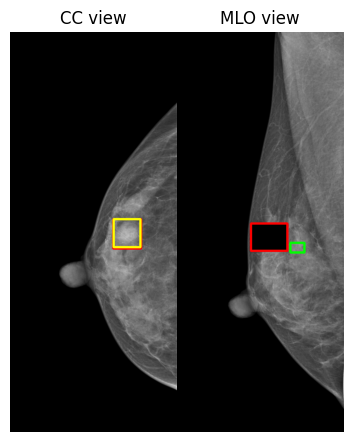

 24%|██████████████████████████████████████████████▍                                                                                                                                                   | 479/2000 [17:28<57:23,  2.26s/it]

True


 24%|██████████████████████████████████████████████▌                                                                                                                                                   | 480/2000 [17:30<56:36,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████▋                                                                                                                                                   | 481/2000 [17:32<56:25,  2.23s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████▊                                                                                                                                                   | 482/2000 [17:34<55:43,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████▊                                                                                                                                                   | 483/2000 [17:37<55:39,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|██████████████████████████████████████████████▉                                                                                                                                                   | 484/2000 [17:39<55:22,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|███████████████████████████████████████████████                                                                                                                                                   | 485/2000 [17:41<55:13,  2.19s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|███████████████████████████████████████████████▏                                                                                                                                                  | 486/2000 [17:43<54:48,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|███████████████████████████████████████████████▏                                                                                                                                                  | 487/2000 [17:45<54:34,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|███████████████████████████████████████████████▎                                                                                                                                                  | 488/2000 [17:47<54:48,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 24%|███████████████████████████████████████████████▍                                                                                                                                                  | 489/2000 [17:50<54:57,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True
torch.Size([1000])
torch.Size([1000])
torch.Size([8, 1000, 1000])
tensor([0.0006], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[202.4219, 714.2738, 269.8416, 769.5321]])


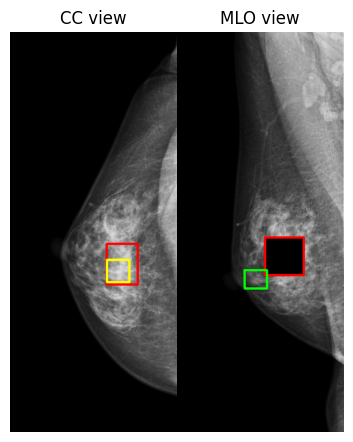

torch.Size([8, 1000, 1000])
tensor([0.0002], grad_fn=<TopkBackward0>)
tensor([0])
tensor([[202.4219, 714.2738, 269.8416, 769.5321]])


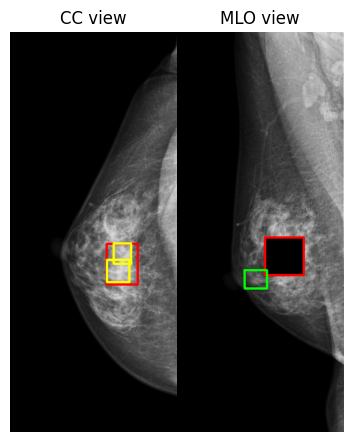

 24%|███████████████████████████████████████████████▌                                                                                                                                                  | 490/2000 [17:52<58:22,  2.32s/it]

True


 25%|███████████████████████████████████████████████▋                                                                                                                                                  | 491/2000 [17:54<56:40,  2.25s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|███████████████████████████████████████████████▋                                                                                                                                                  | 492/2000 [17:57<56:19,  2.24s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|███████████████████████████████████████████████▊                                                                                                                                                  | 493/2000 [17:59<54:49,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|███████████████████████████████████████████████▉                                                                                                                                                  | 494/2000 [18:01<54:43,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████                                                                                                                                                  | 495/2000 [18:03<54:10,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████                                                                                                                                                  | 496/2000 [18:05<54:12,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▏                                                                                                                                                 | 497/2000 [18:07<53:53,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▎                                                                                                                                                 | 498/2000 [18:09<54:22,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▍                                                                                                                                                 | 499/2000 [18:12<54:35,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▌                                                                                                                                                 | 500/2000 [18:14<54:54,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▌                                                                                                                                                 | 501/2000 [18:16<54:17,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▋                                                                                                                                                 | 502/2000 [18:18<55:03,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▊                                                                                                                                                 | 503/2000 [18:20<54:56,  2.20s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▉                                                                                                                                                 | 504/2000 [18:23<55:01,  2.21s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|████████████████████████████████████████████████▉                                                                                                                                                 | 505/2000 [18:25<54:04,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|█████████████████████████████████████████████████                                                                                                                                                 | 506/2000 [18:27<54:04,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|█████████████████████████████████████████████████▏                                                                                                                                                | 507/2000 [18:29<53:48,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|█████████████████████████████████████████████████▎                                                                                                                                                | 508/2000 [18:31<54:06,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 25%|█████████████████████████████████████████████████▎                                                                                                                                                | 509/2000 [18:33<53:27,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|█████████████████████████████████████████████████▍                                                                                                                                                | 510/2000 [18:36<53:09,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|█████████████████████████████████████████████████▌                                                                                                                                                | 511/2000 [18:38<52:36,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|█████████████████████████████████████████████████▋                                                                                                                                                | 512/2000 [18:40<52:57,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|█████████████████████████████████████████████████▊                                                                                                                                                | 513/2000 [18:42<52:58,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|█████████████████████████████████████████████████▊                                                                                                                                                | 514/2000 [18:44<53:11,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|█████████████████████████████████████████████████▉                                                                                                                                                | 515/2000 [18:46<53:17,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████                                                                                                                                                | 516/2000 [18:48<53:10,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▏                                                                                                                                               | 517/2000 [18:51<52:54,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▏                                                                                                                                               | 518/2000 [18:53<53:21,  2.16s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▎                                                                                                                                               | 519/2000 [18:55<53:38,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▍                                                                                                                                               | 520/2000 [18:57<53:48,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▌                                                                                                                                               | 521/2000 [18:59<53:42,  2.18s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▋                                                                                                                                               | 522/2000 [19:01<53:23,  2.17s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▋                                                                                                                                               | 523/2000 [19:04<52:54,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▊                                                                                                                                               | 524/2000 [19:06<52:59,  2.15s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|██████████████████████████████████████████████████▉                                                                                                                                               | 525/2000 [19:08<52:28,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|███████████████████████████████████████████████████                                                                                                                                               | 526/2000 [19:10<52:34,  2.14s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|███████████████████████████████████████████████████                                                                                                                                               | 527/2000 [19:12<52:19,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|███████████████████████████████████████████████████▏                                                                                                                                              | 528/2000 [19:14<51:54,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|███████████████████████████████████████████████████▎                                                                                                                                              | 529/2000 [19:16<51:53,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 26%|███████████████████████████████████████████████████▍                                                                                                                                              | 530/2000 [19:18<52:05,  2.13s/it]

torch.Size([1000])
torch.Size([1000])
True


 27%|███████████████████████████████████████████████████▌                                                                                                                                              | 531/2000 [19:21<51:59,  2.12s/it]

torch.Size([1000])
torch.Size([1000])
True


 27%|███████████████████████████████████████████████████▌                                                                                                                                              | 531/2000 [19:23<53:38,  2.19s/it]


KeyboardInterrupt: 

In [9]:
device='cpu'
#model.roi_heads.score_thresh =0.01
for images_CC, images_MLO, targets_CC, targets_MLO in tqdm(valid_loader_mask):
    images_CC = list(image_CC.to(device) for image_CC in images_CC)
    images_MLO = list(image_MLO.to(device) for image_MLO in images_MLO)
    #images = torch.stack(images)
    #print(images.shape)
    #images = images.to(device)
    targets_CC = [{k: v.to(device) for k, v in t.items()} for t in targets_CC]
    targets_MLO = [{k: v.to(device) for k, v in t.items()} for t in targets_MLO]

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    model_time = time.time()
    model.roi_heads.crossview.decoder.layers[0].train()
    print(model.roi_heads.crossview.decoder.layers[0][0].training)
    outputs_CC, outputs_MLO= model(images_CC, images_MLO, targets_CC, targets_MLO)
        #print('out',outputs)
        #print('tar',targets)
    #####################################
    for i in range(len(images_CC)):
        true_dict_CC = dict()
        true_dict_MLO = dict()
        preds_dict_CC = dict()
        preds_dict_MLO = dict()
        true_dict_CC['boxes'] = targets_CC[i]['boxes']
        true_dict_CC['labels'] = targets_CC[i]['labels']
        preds_dict_CC['boxes'] = outputs_CC[i]['boxes']
        preds_dict_CC['scores'] = outputs_CC[i]['scores']
        preds_dict_CC['labels'] = outputs_CC[i]['labels']
        
        true_dict_MLO['boxes'] = targets_MLO[i]['boxes']
        true_dict_MLO['labels'] = targets_MLO[i]['labels']
        preds_dict_MLO['boxes'] = outputs_MLO[i]['boxes']
        preds_dict_MLO['scores'] = outputs_MLO[i]['scores']
        preds_dict_MLO['labels'] = outputs_MLO[i]['labels']
        img_CC = images_CC[i]
        img_MLO = images_MLO[i]
        #img = invTrans(img)[0]
        img_CC= img_CC.permute(1,2,0)
        img_MLO = img_MLO.permute(1,2,0)
        img_CC = img_CC.cpu().numpy().copy()
        img_MLO = img_MLO.cpu().numpy().copy()
        for j in range(len(true_dict_CC['labels'])):
            x_min, y_min, x_max, y_max = true_dict_CC['boxes'][j]
            img_CC =cv2.rectangle(img=img_CC,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,0,0),thickness =5)
        for j in range(len(true_dict_MLO['labels'])):
            x_min, y_min, x_max, y_max = true_dict_MLO['boxes'][j]
            img_MLO =cv2.rectangle(img=img_MLO,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,0,0),thickness =5)
        for j in range(len(true_dict_CC['labels'])):
            for k in range(len(preds_dict_CC['labels'])):
                if true_dict_CC['labels'][j] == preds_dict_CC['labels'][k]:
                    pred_box= preds_dict_CC['boxes'][k].clone()
                    pred_box[2:] -= pred_box[:2]
                    true_box= true_dict_CC['boxes'][j].clone()
                    true_box[2:]-= true_box[:2]
                    iou_score= get_iou_score(true_box, pred_box)
                    if iou_score>0.2:
                        model.zero_grad()
                        #preds_dict_CC['scores'][i].backward(retain_graph=True)
                        print(model.roi_heads.crossview.decoder.layers[0][0].attn.shape)
                        grad=torch.autograd.grad(preds_dict_CC['scores'][k], [model.roi_heads.crossview.decoder.layers[0][0].attn], retain_graph=True)[0]
                        index_CC = model.roi_heads.index[i]["CC"][k]
                        cam = model.roi_heads.crossview.decoder.layers[0][0].attn
                        #print(model.roi_heads.crossview.decoder.layers[0][0].tgt2.grad)
                        #grad = model.roi_heads.crossview.decoder.layers[0][0].attn.grad
                        cam = grad*cam
                        cam = cam.clamp(min=0).mean(dim=0)
                        R =cam[index_CC]
                        value, indices = torch.topk(R, 1)
                        print(value)
                        print(indices)
                        print(model.roi_heads.proposals[i]['MLO'][indices])
                        x_min, y_min, x_max, y_max = preds_dict_CC['boxes'][k]
                        img_CC =cv2.rectangle(img=img_CC,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,1.0,0),thickness =5)
                        #score =preds_dict_CC['scores'][k]
                        #cv2.putText(img_CC, f'{score}', (int(x_min), int(y_min-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (1.0,1.0,0), 5)
                        for boxes_MLO in model.roi_heads.proposals[i]['MLO'][indices]:
                            x_min, y_min, x_max, y_max = boxes_MLO
                            img_MLO = cv2.rectangle(img=img_MLO,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (0,1.0,0),thickness =5)
                        aspect= 1200/500
                        n = 1 # number of rows
                        m = 2 # numberof columns
                        bottom = 0.1; left=0.05
                        top=1.-bottom; right = 1.-left
                        fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
                        #widthspace, relative to subplot size
                        wspace=0.  # set to zero for no spacing
                        hspace=wspace/float(aspect)
                        #fix the figure height
                        figheight= 5 # inch
                        figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp
                        fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
                        plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left,wspace=wspace, hspace=hspace) 
                        axs[0].imshow(img_CC)
                        axs[0].axis('off')
                        axs[0].set_title("CC view")
                        axs[1].imshow(img_MLO)
                        axs[1].axis('off')
                        axs[1].set_title("MLO view")
                        plt.show()